In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys
import numpy as np
import time
import pickle

In [ ]:
computer_name = os.uname()[1]
if computer_name == "apas":
    img_dir = "/home/wenjian/data/flickr30kentities/flickr30k-images/"  # For visualization
    
    features_dir = "/home/wenjian/data/flickr30kentities/bottom-up-feats/"
    
    #train_image_list_filepath = "/home/wenjian/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    train_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/val_queries.csv"
    
    test_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/test_2016_flickr_queries.csv"

    xml_dirpath = "/home/wenjian/data/flickr30kentities/annotations/Annotations/"

    project_root = "/home/wenjian/code/"
    
    pretrained_model_path = None


else:
    raise Exception("Failed to initialize paths: computer not recognized")
print(computer_name)

In [4]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [5]:
class CFG:
    def __init__(self):
        # cfg_path for future use
        self.xml_dirpath = xml_dirpath
        self.triple_filepaths = {'train': train_triple_filepath,
                                 'val': val_triple_filepath,
                                 'test': test_triple_filepath
                                }
        self.RPN_TOPN = 100
        
        # Configure for network
        self.WORD_EMB_SIZE = 300
        self.RNN_DIM = 1024
        self.VISUAL_FEATURES = 2048  # For resnet
        self.SPATIAL_FEATURES = 5
        self.SOFTLABEL_THRESHOLD = 0.5 # 0.5 in paper
        self.GAMMA = 1
        self.DELTA = 1
        self.STEMMING = False
        self.epsilon = 1e-7
        self.dropout_rate = 0.5
        self.lr_decay_rate = 0.7
        self.initial_lr = 0.001
        self.use_pretrained_word_embedding = None  # candidate: None, "GloVe"
        self.use_pretrained_model = False
        self.regression_loss = False
        
cfg = CFG()

## Establish vocabulary dictionary from training set    

In [6]:
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import gensim
import pandas as pd

In [7]:
train_df = pd.read_csv(train_triple_filepath)

stemmer = SnowballStemmer("english")
corpus_list = train_df["entity_content"].values.tolist()
corpus_list = ['EMPTYWORDTOKEN', 'UNKNOWNWORD'] + corpus_list  # 'EMPTYWORDTOKEN' is the token for empty word. It is needed because the input data for word embedding layer require padding. 


In [9]:
if cfg.STEMMING:
    corpus = [[stemmer.stem(w) for w in word_tokenize(q)] for q in corpus_list]
else: 
    corpus = [[w.lower() for w in word_tokenize(q)] for q in corpus_list]
# corpus is a list of list of string

In [13]:
training_corpus_dct = gensim.corpora.Dictionary(corpus)
freq = list(training_corpus_dct.dfs.values())

## Dataset statistics

In [ ]:
# For English
general_df = pd.read_csv(test_triple_filepath)
corpus_list_en = general_df["entity_content"].values.tolist() 

In [36]:
corpus_en = [[w.lower() for w in word_tokenize(q)] for q in corpus_list_en]
general_corpus_dct_en = gensim.corpora.Dictionary(corpus_en)

## Data Generation

In [14]:
from torch.utils import data
import pandas as pd
import xml.etree.ElementTree as ET
# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
class DDPNDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, cfg, phase):
        'Initialization'
        self.cfg = cfg
        self.phase = phase
        self.df_triple = pd.read_csv(self.cfg.triple_filepaths[self.phase])  # Triple means (image, ground_truth_bounding_box, query)
        

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df_triple.index)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        imageID = str(self.df_triple.iloc[index]["imgId"])
        entityID = str(self.df_triple.iloc[index]["entityId"])
        
        # Load data and get label
        zf = np.load(features_dir+imageID+'.jpg.npz')
        num_bbox = zf['num_bbox']
        visual_feat = zf['x']  # visual_feat's shape here is supposed to be (2048, num_bbox) for resnet, (4096, num_bbox) for vgg16
        visual_feat = np.transpose(visual_feat) # now (num_bbox, 2048) for resnet, (num_bbox, 4096) for vgg16
        spatial_feat = zf['bbox'] # spatial_feat's shape here is supposed to be (num_bbox, 4)
        x1 = spatial_feat[:,0]
        y1 = spatial_feat[:,1]
        x2 = spatial_feat[:,2]
        y2 = spatial_feat[:,3]
        image_w = zf['image_w']
        image_h = zf['image_h']
        spatial_feat = np.column_stack((x1/image_w, y1/image_h, x2/image_w, y2/image_h, (x2-x1)*(y2-y1)/(image_w*image_h)))
        
        # Concatenate visual features and spatial features
        X = np.column_stack((visual_feat, spatial_feat))
        
        # If there are fewer than self.cfg.RPN_TOPN=100 proposals, add 0 rows below
        for i in range(X.shape[0], self.cfg.RPN_TOPN):
            zero_row = np.zeros((1,X.shape[1]))
            X = np.vstack((X, zero_row))
        # Convert numpy array to torch tensor 
        X = torch.from_numpy(X)
        X = X.float()
        
        query = self.df_triple.iloc[index]["entity_content"]
        
        # Get ground truth bounding box
        gt_bbox = self._get_bounding_box(imageID, entityID) # gt_bbox is a triple in format (x1, y1, x2, y2)
        # Get the bounding box boundary regard as image size
        gt_bbox[0] /= float(image_w)
        gt_bbox[2] /= float(image_w)
        gt_bbox[1] /= float(image_h)
        gt_bbox[3] /= float(image_h)
        # Convert list to torch tensor
        gt_bbox = torch.tensor(gt_bbox) 
        
        additional_info = (imageID, entityID, image_w, image_h) # those info are not directly used in training, but used in visualization

        return (X, query), gt_bbox, additional_info  
    
    def _get_bounding_box(self, image_id, object_id): # image_id and object_id are expected to be string
         
        xml_tree = ET.parse(self.cfg.xml_dirpath + image_id + '.xml')
        root = xml_tree.getroot()
        boxes = []  # To deal with one object, multiple bounding boxes
        for obj in root.findall('object'):
            for name in obj.findall('name'):
                if name.text == object_id:
                    bndbox = obj.find("bndbox")
                    x1 = int(bndbox.find("xmin").text)
                    y1 = int(bndbox.find("ymin").text)
                    x2 = int(bndbox.find("xmax").text)
                    y2 = int(bndbox.find("ymax").text)
                    
                    boxes.append([x1, y1, x2, y2])
        if len(boxes)==0:
            raise Exception("Entity not found. Image id: "+image_id+", Entity id: "+object_id)
        boxes_array = np.array(boxes)
        # When there are multiple bounding boxes, draw the minimum box which contains all these invidual boxes
        x1 = np.min(boxes_array[:,0])
        y1 = np.min(boxes_array[:,1])
        x2 = np.max(boxes_array[:,2])
        y2 = np.max(boxes_array[:,3])
                    
        return [x1, y1, x2, y2]        

In [15]:
training_set = DDPNDataset(cfg, 'train')
validation_set = DDPNDataset(cfg, 'val')
test_set = DDPNDataset(cfg, 'test')

### Calculate IoU score between two boxes

In [16]:
def intersect(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    inter_xmin=torch.max(box_a[:,:,0], box_b[:,:,0])
    inter_xmax=torch.min(box_a[:,:,2], box_b[:,:,2])
    inter_ymin=torch.max(box_a[:,:,1], box_b[:,:,1])
    inter_ymax=torch.min(box_a[:,:,3], box_b[:,:,3])
    inter = torch.max((inter_xmax-inter_xmin).float(), torch.tensor(0).float().to(box_a.device)) * torch.max((inter_ymax-inter_ymin).float(), torch.tensor(0).float().to(box_a.device))
    return inter

In [17]:
def IoU(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    # The shape of each input: (batch_size, box_number_in_each_image, 4)
    box_a = box_a.float() 
    box_b = box_b.float()
    inter = intersect(box_a, box_b)
    area_a = (box_a[:,:,2] - box_a[:,:,0]) * (box_a[:,:,3] - box_a[:,:,1])
    area_b = (box_b[:,:,2] - box_b[:,:,0]) * (box_b[:,:,3] - box_b[:,:,1])
    union = area_a + area_b - inter
    return inter.float() / union.float()

### Calculate softlable

In [18]:
def get_softlabel_wrapper(threshold, epsilon):
    def get_softlable(X, gt_bbox): # gt_bbox is expected as a triple in format (x1, y1, x2, y2). All the four boundaries are between 0 and 1. Batch is not considered here
        # X is expected in shape (batch_size, N, 2053). We use the 4 columns with indexes 2047-2051. It should be noted that the last column in X is the area so we should not use it. 
        # gt_bbox is expected in format tensor with shape (batch_size, 4)
        gt_bbox = gt_bbox.unsqueeze(1)
        iou = IoU(X[:,:,-5:-1], gt_bbox.repeat((1,cfg.RPN_TOPN,1)))   #.double()
        iou_with_threshold = iou*(iou>threshold).float()
        denominator = iou_with_threshold.sum(dim=1).unsqueeze(1) + epsilon
        iou_with_threshold_l1_norm = iou_with_threshold / denominator
        return iou_with_threshold_l1_norm
    return get_softlable
get_softlable = get_softlabel_wrapper(cfg.SOFTLABEL_THRESHOLD, torch.tensor(cfg.epsilon).to(device)) 

In [19]:
def loss_wrapper(cfg):
    def my_loss(predict, target):  # predict is expected to be (s,t), target their ground truth value
        s, t = predict
        gt_s, gt_t = target
        s = torch.add(s, torch.tensor(cfg.epsilon))  # In order to avoid 0 in the denominator
        try:

            loss_ranking = F.kl_div(torch.log(s), gt_s, reduction='batchmean') 
            assert not torch.isnan(loss_ranking).any()
            assert not torch.isinf(loss_ranking).any()
            logger.add_scalar("ranking_loss", loss_ranking, my_loss.counter)
            if cfg.regression_loss:
                N = t.size()[1]

                loss_regression = F.smooth_l1_loss(t, gt_t.unsqueeze(1).repeat(1,N,1), reduction='mean')

                logger.add_scalar("regression_loss", cfg.GAMMA*loss_regression, my_loss.counter)
            my_loss.counter += 1 
            
        except AssertionError as e:
            torch.set_printoptions(profile='full')
            print('s\n', s)
            print('t\n', t)
            print('gt_s\n', gt_s)
            print('gt_t\n', gt_t)
            with open("debug.log", 'w') as log:
                log.write('s\n')
                log.write(str(s))
                log.write('gt_s\n')
                log.write(str(gt_s))
            torch.set_printoptions(profile='default')
            raise e
        
        if cfg.regression_loss:
            return loss_ranking + cfg.GAMMA*loss_regression
        else:
            return loss_ranking 
    my_loss.counter = 0
    return my_loss
loss_func = loss_wrapper(cfg)

In [31]:
def pad_sequence_right_alignment(sequences, batch_first=False, padding_value=0):
    """
    Arguments:
        sequences (list[Tensor]): list of variable length sequences.
        batch_first (bool, optional): output will be in ``B x T x *`` if True, or in
            ``T x B x *`` otherwise
        padding_value (float, optional): value for padded elements. Default: 0.
    
    
    """
    # assuming trailing dimensions and type of all the Tensors
    # in sequences are same and fetching those from sequences[0]
    max_size = sequences[0].size()
    trailing_dims = max_size[1:]
    max_len = max([s.size(0) for s in sequences])
    if batch_first:
        out_dims = (len(sequences), max_len) + trailing_dims
    else:
        out_dims = (max_len, len(sequences)) + trailing_dims

    out_tensor = sequences[0].data.new(*out_dims).fill_(padding_value)
    for i, tensor in enumerate(sequences):
        length = tensor.size(0)
        # use index notation to prevent duplicate references to the tensor
        if batch_first:
            out_tensor[i, -length:, ...] = tensor  # Modification 1/2
        else:
            out_tensor[-length:, i, ...] = tensor  # Modification 2/2

    return out_tensor

In [20]:
if cfg.use_pretrained_word_embedding == None:
    tokenized_sentence_to_indices = training_corpus_dct.doc2idx
elif cfg.use_pretrained_word_embedding == "GloVe":
    # To convert a tokenized document to a list of list of index of each word
    def doc2idx_glove_wrapper(glove_object):
        def doc2idx_glove(doc): # doc is a list of list of word(string)
            return [[glove_object.stoi[word] for word in line] for line in doc]
        return doc2idx_glove
    # To convert a tokenized sentence to a list of index of each word
    def snt2idx_glove_wrapper(glove_object):
        def snt2idx_glove(snt): # snt is a list of list of word(string)
            return [glove_object.stoi[word] for word in snt]
            #due to torchtext.
        return snt2idx_glove
    doc2idx_glove = doc2idx_glove_wrapper(glove)
    snt2idx_glove = snt2idx_glove_wrapper(glove)
    tokenized_sentence_to_indices = snt2idx_glove

In [21]:
class DDPN(torch.nn.Module):
    def __init__(self, cfg, vocab_size=None, embedding_weights=None):
        super(DDPN, self).__init__()
        self.cfg = cfg
        if type(embedding_weights) == type(None):
            #print("type(embedding_weights) equals to type(None)")
            assert isinstance(vocab_size, int), "Error: you are using non-pretraind embedding, and vocab_size is not an integer, but {}.".format(vocab_size)
            self.embedding = nn.Embedding(vocab_size, self.cfg.WORD_EMB_SIZE)  
            self.embedding.requires_grad = True
        else:
            #print("type(embedding_weights) doesn't equal to type(None)")
            self.embedding = nn.Embedding(embedding_weights.size()[0], embedding_weights.size()[1])
            self.embedding.load_state_dict({'weight': embedding_weights})
            self.embedding.requires_grad = False
        self.lstm = nn.LSTM(self.cfg.WORD_EMB_SIZE, self.cfg.RNN_DIM)  # This lstm is batch_first=false
        self.fc1 = nn.Linear(self.cfg.VISUAL_FEATURES+self.cfg.SPATIAL_FEATURES+self.cfg.RNN_DIM, 512)
        # Pytorch's Linear layer automatically exerts on the last dimension of the tensor, so we don't need to take care of N=100 manually. 
        self.fc_rank = nn.Linear(512,1)
        if cfg.regression_loss:
            self.fc_regression = nn.Linear(512,4)
        self.batchnorm = torch.nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(cfg.dropout_rate)
        self.softmax = nn.Softmax(dim=1)
        
        #self.frozen_layers = [self.embedding, self.lstm, self.fc1, self.fc_rank]
#         for param in networkB.conv1.parameters():
#             param.requires_grad = False
        
        
    def forward(self, Xs, queries, seq_lengths):
        
        # one piece of query here should be a 1d tensor of indices (index of each word in the corpus dictionary) 
        # queries is a batch of query
        # seq_lengths is the length of each query
        
        batch_size = Xs.size()[0]
        
        emb = self.embedding(queries) # emb size is (time_sequence, batch_size, 300)
        emb_packed = torch.nn.utils.rnn.pack_padded_sequence(emb, lengths=seq_lengths, batch_first=False, enforce_sorted=False)
        qs = self.lstm(emb_packed)[0] # [0] is to choose the output h_t sequence
        # qs.size() is (time_sequence, batch_size, 1024)
        qs_unpacked, qs_len = torch.nn.utils.rnn.pad_packed_sequence(qs, batch_first=False)
        qs_unpacked_batch_first = qs_unpacked.permute(1,0,2)
        q = qs_unpacked_batch_first[torch.arange(batch_size),qs_len-1] # to choose the output feature of last word
        #print("q0", q0.type(), q0.size())  # The shape is (64, 1024)
        
        q_tiled = q.unsqueeze(1).repeat((1,self.cfg.RPN_TOPN,1)) #.double()
        x_concat = torch.cat((Xs, q_tiled), dim=2)  # x_concat's shape is expected as (batch_size, 100, 2053+1024)
        x1_linear = self.fc1(x_concat) 
        x1 = F.relu(x1_linear)
        x1 = x1.permute(0,2,1)
        x1 = self.batchnorm(x1)
        x1 = x1.permute(0,2,1)
        x1_dropped = self.dropout(x1)
        # x1's shape is expected as (batch_size, 100, 512)
        s0 = self.fc_rank(x1_dropped).squeeze()  # s's shape is expected to be (batch_size, 100)
        s = self.softmax(s0)
        if cfg.regression_loss:
            t = self.fc_regression(x1_dropped)
            return (s, t)
        else:
            return (s, None)
        

In [22]:
def preprocess_query(queries):  
    # queries is a tuple of strings. The length of queries is the batch size. 
    if cfg.STEMMING:
        indices = [tokenized_sentence_to_indices([stemmer.stem(w) for w in word_tokenize(q)]) for q in queries]
    else:
        indices = [tokenized_sentence_to_indices([w.lower() for w in word_tokenize(q)]) for q in queries]

    if cfg.use_pretrained_word_embedding == None:
        # Gensim assign -1 to unknown word in the dictionary. 
        # Pytorch embedding, however, don't support negative index. 
        # So we kept 1 for unknown word when building Gensim dictionary, and convert -1 to 1 now
        indices = [[idx if idx!=-1 else 1 for idx in row] for row in indices]
    elif cfg.use_pretrained_word_embedding == "GloVe":
        # Torchtext's GloVe raise KeyError when encountering a token not found
        raise Exception("Part not implemented.")  # Need modification somewhere else
    else:
        raise Exception("Illegal value for the parameter cfg.use_pretrained_word_embedding.")
    
    seq_lengths = [len(row) for row in indices]
    
    Qs_before_padding = [torch.tensor(row) for row in indices]
    
    if cfg.use_pretrained_word_embedding == None:
        padding_value = 0
    elif cfg.use_pretrained_word_embedding == "GloVe":
        padding_value = 1  # 1 is '.', since in GloVe there is no empty word token
    
    Qs = nn.utils.rnn.pad_sequence(Qs_before_padding, batch_first=False, padding_value=padding_value)
    # Qs = pad_sequence_right_alignment(Qs_before_padding, batch_first=False, padding_value=padding_value)
    
    return Qs, seq_lengths
    

In [23]:
def calculate_IoU_scores_wrapper(cfg):
    def calculate_IoU_scores(Xs, pred, gt_bboxes):
        s, t = pred
        proposal_chosen = torch.argmax(s, dim=1)
        batch_size = Xs.size()[0]
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
        ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()
        if cfg.regression_loss:
            bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
            ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze()
            return ious_original, ious_refined
        return ious_original
    return calculate_IoU_scores
calculate_IoU_scores = calculate_IoU_scores_wrapper(cfg)

In [21]:
import datetime
from tensorboardX import SummaryWriter
run_comment = "_L1-gt-softlabel_drop0.5_for-word2word-test"
moment = datetime.datetime.now()
run_name = str(moment.date()) + f"_{moment.hour}-{moment.minute}-{moment.second}" + run_comment


output_root = os.path.join(project_root, "experiments/")
output_dir_name = run_name  
output_dir = os.path.join(output_root, output_dir_name)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
pytorch_model_save_path = output_dir
pytorch_result_save_path = output_dir
pytorch_checkpoint_save_path = output_dir


#log_dir = os.path.join("runs/", run_name)
log_dir = os.path.join(output_dir, "log")
os.mkdir(log_dir)
print(output_dir)
logger = SummaryWriter(log_dir)
train_logger = SummaryWriter(os.path.join(log_dir, "training"))
val_logger = SummaryWriter(os.path.join(log_dir, "validation"))
train_iou_before_refinement_logger = SummaryWriter(os.path.join(log_dir, "train_iou_before_refinement"))
val_iou_before_refinement_logger = SummaryWriter(os.path.join(log_dir, "val_iou_before_refinement"))
if cfg.regression_loss:
    train_iou_after_refinement_logger = SummaryWriter(os.path.join(log_dir, "train_iou_after_refinement"))
    val_iou_after_refinement_logger = SummaryWriter(os.path.join(log_dir, "val_iou_after_refinement"))

pth_filename = "ddpn.pth"
checkpoint_filename_base = "checkpoint_"  # eg. checkpoint_3.tar means the chechpoint after epoch=3
process_filename = "process.dct" # .dct here simply means saving a dictionary in binary mode by pickle

/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/word2word_test_set/experiments/2019-10-20_21-45-46_L1-gt-softlabel_drop0.5_for-word2word-test


In [ ]:
# https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

# Parameters
params = {'batch_size': 64,
          'num_workers': 2}

training_generator = data.DataLoader(training_set, shuffle=True, **params)
validation_generator = data.DataLoader(validation_set, shuffle=True, **params)
test_generator = data.DataLoader(test_set, shuffle=True, **params)



if cfg.use_pretrained_word_embedding == None:
    print("Non-pretrained embedding is used.")
    model = DDPN(cfg, vocab_size=len(training_corpus_dct.token2id))
elif cfg.use_pretrained_word_embedding == "GloVe":
    print("Glove embedding is used.")
    model = DDPN(cfg, embedding_weights=glove.vectors)
else:
    raise Exception("Embedding configuration not recognized")
    

if cfg.use_pretrained_model:    
    print("loading pre-trained model from ", pretrained_model_path)
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
    

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=cfg.initial_lr) 
LR_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=cfg.lr_decay_rate)
# Warning: Pytorch's Adam does not have the learning rate decay feature. 
#          Possibly learning rate scheduler may achieve the same effect. 
# Warning: beta2 is recommended as 0.999 in the original paper and by the community. 


print("training on device:", device)
print("log in directory:", logger.logdir)
print("gamma:", cfg.GAMMA)

process = {}
process['time'] = []
process['train_average_losses_by_epoch'] = []
process['val_average_losses_by_epoch'] = []
process['train_IoU_acc_before_refinement'] = []
process['val_IoU_acc_before_refinement'] = []
if cfg.regression_loss:
    process['train_IoU_acc_after_refinement'] = []
    process['val_IoU_acc_after_refinement'] = []
train_losses = []
val_losses = []
process['configure'] = cfg



# Loop over epochs
max_epochs = 20
time_start_all = time.time()
loss = None
train_batch_counter_total = 0
val_batch_counter_total = 0

for epoch in range(max_epochs):
    time_start = time.time()
    # Training
    #train_batch_counter = 0
    train_losses_by_epoch = []
    train_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    train_all_ious_original = []
    if cfg.regression_loss:
        train_all_ious_refined = []
    
    #for inputs, gt_bboxes in training_generator:
    for train_batch_counter, (inputs, gt_bboxes, _) in enumerate(training_generator):
        
        model.train()
        
        optimizer.zero_grad()
        
        Xs, queries = inputs
     
        Qs, seq_lengths = preprocess_query(queries)

        
        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
        
        pred = model(Xs, Qs, seq_lengths)
        targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
        try:
            loss = loss_func(pred, targ)
        except AssertionError as e:
            print(f"epoch {epoch}, train, batch: {train_batch_counter}")
            with open("debug.log", 'a') as log:
                log.write(f"epoch {epoch}, train, batch: {train_batch_counter}\n")
            raise e
        train_losses_by_epoch.append(loss.item())
        train_loss_average_by_epoch += loss.item()*Xs.size(0)
        
        loss.backward()
        optimizer.step()
        
        
        print(f"\repoch {epoch}, training phase, batch {train_batch_counter}/{len(training_generator)}, loss={loss.item()}", end='')
        logger.add_scalar("train_loss_by_batch", loss.item(), train_batch_counter_total)
        
        # statistics of IoU score
        if cfg.regression_loss:
            ious_original, ious_refined = calculate_IoU_scores(Xs, pred, gt_bboxes)
        else:
            ious_original = calculate_IoU_scores(Xs, pred, gt_bboxes)

        train_all_ious_original = train_all_ious_original + ious_original.tolist()
        if cfg.regression_loss:
            train_all_ious_refined = train_all_ious_refined + ious_refined.tolist()
        
        train_batch_counter_total += 1
        
        
    train_losses.append(train_losses_by_epoch)
    train_loss_average_by_epoch /= len(training_generator.dataset)
    print("\repoch", epoch, ", training phase finished, average loss:",train_loss_average_by_epoch)
    train_logger.add_scalar("average_loss_by_epoch", train_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    train_good_original = torch.tensor(train_all_ious_original) > 0.5     
    train_acc_original = train_good_original.sum().float()/len(training_set)
    print("\tTraining: accuracy based on original bounding box:", train_acc_original.item())
    train_iou_before_refinement_logger.add_scalar("IoU_accuracy", train_acc_original, epoch)

    if cfg.regression_loss:
        train_good_refined = torch.tensor(train_all_ious_refined) > 0.5
        train_acc_refined = train_good_refined.sum().float()/len(training_set)
        print("\tTraining: accuracy of refined bounding box:", train_acc_refined.item())
        train_iou_after_refinement_logger.add_scalar("IoU_accuracy", train_acc_refined, epoch)

    # Validation
    val_losses_by_epoch = []
    val_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    val_all_ious_original = []
    if cfg.regression_loss:
        val_all_ious_refined = []
    
    with torch.no_grad():      
        #for inputs, gt_bboxes in validation_generator:
        for val_batch_counter, (inputs, gt_bboxes, _) in enumerate(validation_generator):
            Xs, queries = inputs
           
            Qs, seq_lengths = preprocess_query(queries)
            
            model.eval()
            
            Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
            
            val_pred = model(Xs, Qs, seq_lengths)
            val_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
            try:
                val_loss = loss_func(val_pred, val_targ)
            except AssertionError as e:
                print(f"epoch {epoch}, val, batch: {val_batch_counter}")
                with open("debug.log", 'a') as log:
                    log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
                raise e
            val_losses_by_epoch.append(val_loss.item())
            val_loss_average_by_epoch += val_loss.item()*Xs.size(0)
        
            print(f"\repoch {epoch}, validation phase, batch {val_batch_counter}/{len(validation_generator)}, val_loss={val_loss.item()}", end='')
            logger.add_scalar("val_loss_by_batch", val_loss.item(), val_batch_counter_total)
            
            # Statistics of IoU score
            if cfg.regression_loss:
                ious_original, ious_refined = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            else:
                ious_original = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            val_all_ious_original = val_all_ious_original + ious_original.tolist()
            if cfg.regression_loss:
                val_all_ious_refined = val_all_ious_refined + ious_refined.tolist()
            
            val_batch_counter_total += 1
            
    LR_scheduler.step() # Decay the learning rate every epoch
    
    val_losses.append(val_losses_by_epoch)
    val_loss_average_by_epoch /= len(validation_generator.dataset)
    print("\repoch", epoch, ", validation phase finished, average loss:",val_loss_average_by_epoch)
    val_logger.add_scalar("average_loss_by_epoch", val_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    val_good_original = torch.tensor(val_all_ious_original) > 0.5     
    val_acc_original = val_good_original.sum().float()/len(validation_set)
    print("\tValidation: accuracy based on original bounding box:", val_acc_original.item())
    val_iou_before_refinement_logger.add_scalar("IoU_accuracy", val_acc_original, epoch)

    if cfg.regression_loss:
        val_good_refined = torch.tensor(val_all_ious_refined) > 0.5
        val_acc_refined = val_good_refined.sum().float()/len(validation_set)
        print("\tValidation: accuracy of refined bounding box:", val_acc_refined.item())
        val_iou_after_refinement_logger.add_scalar("IoU_accuracy", val_acc_refined, epoch)    
    
    
    
    time_end = time.time()
    time_epoch = time_end - time_start
    print(f"epoch {epoch} finished. Time used: {time_epoch}")
    
    model.eval() # Do this before saving the model when dropout or batch normalization is involved. https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # Save model's learnable parameters
    torch.save(model.state_dict(), os.path.join(pytorch_model_save_path,pth_filename))
    # Save checkpoint
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                
                }, os.path.join(pytorch_checkpoint_save_path, (checkpoint_filename_base+str(epoch)+'.tar')))
    
    # Save loss (value) evolution
    process['train_losses'] = train_losses
    process['val_losses'] = val_losses
    process['train_average_losses_by_epoch'].append(train_loss_average_by_epoch)
    process['val_average_losses_by_epoch'].append(val_loss_average_by_epoch)
    process['train_IoU_acc_before_refinement'].append(train_acc_original)
    process['val_IoU_acc_before_refinement'].append(val_acc_original)
    if cfg.regression_loss:
        process['train_IoU_acc_after_refinement'].append(train_acc_refined)
        process['val_IoU_acc_after_refinement'].append(val_acc_refined)
    process['time'].append(time_epoch)
    with open(os.path.join(pytorch_result_save_path, process_filename), 'wb') as fp:
        pickle.dump(process, fp)
        
    # the vocabulary dictionary also needs saving in the future

time_end_all = time.time()
time_total = time_end_all - time_start_all
print(f"total time: {time_total}")
process["total_time"] = time_total

with open(os.path.join(pytorch_result_save_path, process_filename), 'wb') as fp:
    pickle.dump(process, fp)

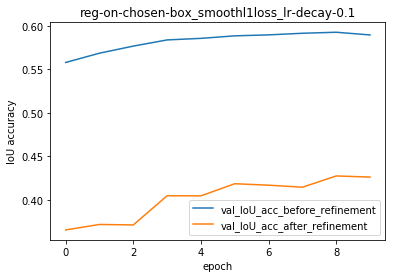

In [95]:
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('IoU accuracy')
plt.title('reg-on-chosen-box_smoothl1loss_lr-decay-0.1')
plt.plot(process['val_IoU_acc_before_refinement'], label='val_IoU_acc_before_refinement')
plt.plot(process['val_IoU_acc_after_refinement'], label='val_IoU_acc_after_refinement')
plt.legend()

In [ ]:
with open("/home/wenjian/Internship/DDPN_transfer/outputs/2019-08-06_19-53-21_gereral-dictionary-mapping_ranking-loss-only/process.dct", "rb") as f:
    loaded_process = pickle.load(f)

## Test set accuracy

In [22]:
en_vocab = len(training_corpus_dct.token2id)

model_test = DDPN(cfg, vocab_size=en_vocab)

#model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
model_to_test_path = pretrained_model_path
checkpoint = torch.load(model_to_test_path, map_location=device)

if not cfg.regression_loss:  # In case of the pretrained model has regression loss while now not
    try:
        checkpoint['model_state_dict'].pop("fc_regression.weight")
        checkpoint['model_state_dict'].pop("fc_regression.bias")
    except KeyError:
        pass

model_test.load_state_dict(checkpoint['model_state_dict'])

model_test.to(device)

DDPN(
  (embedding): Embedding(14384, 300)
  (lstm): LSTM(300, 1024)
  (fc1): Linear(in_features=3077, out_features=512, bias=True)
  (fc_rank): Linear(in_features=512, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [23]:
# Parameters
params = {'batch_size': 64,
          'num_workers': 2}
test_generator = data.DataLoader(test_set, shuffle=False, **params)

In [24]:
# For statistics of IoU score
test_all_ious_original = []
if cfg.regression_loss:
    test_all_ious_refined = []
    
print(f"Evaluating on test set: {len(test_set)} samples" )
with torch.no_grad():      
    for test_batch_counter, (inputs, gt_bboxes, _) in enumerate(test_generator):
        Xs, queries = inputs

        Qs, seq_lengths = preprocess_query(queries)

        model_test.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        test_pred = model_test(Xs, Qs, seq_lengths)
        test_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)

        # Statistics of IoU score
        if cfg.regression_loss:
            ious_original, ious_refined = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
        else:
            ious_original = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
        test_all_ious_original = test_all_ious_original + ious_original.tolist()
        if cfg.regression_loss:
            test_all_ious_refined = test_all_ious_refined + ious_refined.tolist()
    
    good_original = torch.tensor(test_all_ious_original) > 0.5     
    print("Test set: good bounding box based on original bounding box:", good_original.sum().item())
    acc_original = good_original.sum().float()/len(test_set)
    print("Test set: accuracy based on original bounding box:", acc_original.item())

Evaluating on test set: 2789 samples
Test set: good bounding box based on original bounding box: 1737
Test set: accuracy based on original bounding box: 0.6228038668632507


word2word translate: 62.28%

## Draw bounding box in image

In [24]:
import PIL
from PIL import Image, ImageDraw
import os

def draw_bounding_box(filepath_sourceimage, bbox, color, output_dir="", output_name=""):
    """
    Arguemnts:
        filepath: the path to the image file.
        bbox: a 4-element list to describe a bounding box; format: [x1,y1,x2,y2]
        color: a 3-element tuple or a string to describe a color. Example(pure red): (255,0,0) or "#ff0000" or "red"
    """
    img_name = os.path.basename(filepath_sourceimage)

    if isinstance(color, str):
        color = PIL.ImageColor.getrgb(color)

    img = Image.open(filepath_sourceimage).convert("RGBA")
    tmp = Image.new('RGBA', img.size, (0,0,0,0))
    draw = ImageDraw.Draw(tmp)
    draw.rectangle(bbox, fill=color+(32,), outline=color, width=2)
    img = Image.alpha_composite(img, tmp)
    img = img.convert("RGB") # Remove alpha for saving
    if output_name == "":
        out_img_name = 'bbox_' + img_name
    else:
        out_img_name = output_name
    output_path = os.path.join(output_dir, out_img_name)
    img.save(output_path)
    return output_path

In [25]:
def draw_multiple_bounding_boxes(filepath_sourceimage, bbox_color_tuple_list, output_dir="", output_name=""):
    """
    Arguemnts:
        filepath: the path to the image file.
        bbox_color_tuple_list: a list of (bbox, color) tuple, where
            bbox: a 4-element list to describe a bounding box; format: [x1,y1,x2,y2]
            color: a 3-element tuple or a string to describe a color. Example(pure red): (255,0,0) or "#ff0000" or "red"
    """
    img_name = os.path.basename(filepath_sourceimage)
    
    img = Image.open(filepath_sourceimage).convert("RGBA")
    
    
    for bbox, color in bbox_color_tuple_list:
        if isinstance(color, str):
            color = PIL.ImageColor.getrgb(color)
        tmp = Image.new('RGBA', img.size, (0,0,0,0))
        draw = ImageDraw.Draw(tmp)
        draw.rectangle(bbox, fill=color+(32,), outline=color, width=2)
        img = Image.alpha_composite(img, tmp)
        
    img = img.convert("RGB") # Remove alpha for saving
    if output_name == "":
        out_img_name = 'bbox_' + img_name
    else:
        out_img_name = output_name     
    output_path = os.path.join(output_dir, out_img_name)
    img.save(output_path)
    return output_path

In [106]:
if not os.path.exists("./visualization/"):
    os.mkdir("./visualization/")

validation_generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)

with torch.no_grad():
        
    batch_number = 1 # batch_number begins by 0, until last batch in validation set

    #for inputs, gt_bboxes in validation_generator:
    it = iter(validation_generator_for_visualization)
    for i in range(batch_number+1):
        inputs, gt_bboxes, IDs = next(it)
    Xs, queries = inputs
    img_ids, obj_ids, img_ws, img_hs = IDs


    Qs, seq_lengths = preprocess_query(queries)

    model.eval()

    Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

    val_pred = model(Xs, Qs, seq_lengths)
    val_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
    try:
        val_loss = loss_func_testing(val_pred, val_targ)
    except AssertionError as e:
        print(f"epoch {epoch}, val, batch: {val_batch_counter}")
        with open("debug.log", 'a') as log:
            log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
        raise e
    print(val_loss.item())


    # Statistics of IoU score

    s, t = val_pred
    proposal_chosen = torch.argmax(s, dim=1)
    batch_size = Xs.size()[0]
    gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
    bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
    bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
    #print(bboxes_chosen.size())
    ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()  
    ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze() 
    
    
    def get_bbox_in_original_scale(boxes, img_ws, img_hs, sample_in_batch):
        box = boxes[sample_in_batch].tolist()[0]  # [0] is to remove a pair of []
        #print(box)
        #print(img_ws[sample_in_batch])
        #print(img_hs[sample_in_batch])
        #print(img_ws[sample_in_batch].data.cpu().numpy())
        box[0] *= img_ws[sample_in_batch].item()
        box[1] *= img_hs[sample_in_batch].item()
        box[2] *= img_ws[sample_in_batch].item()
        box[3] *= img_hs[sample_in_batch].item()
        #print("box[0]", box[0])
        return box
    
    for sample_in_batch in range(0,64): # Change here to see a different sample

        gt_box = get_bbox_in_original_scale(gt_bboxes, img_ws, img_hs, sample_in_batch)
        first_box = get_bbox_in_original_scale(bboxes_chosen_original, img_ws, img_hs, sample_in_batch)
        refined_first_box = get_bbox_in_original_scale(bboxes_chosen_refined, img_ws, img_hs, sample_in_batch)

        boxes_colors = [(gt_box, "green"),
                        (first_box, "yellow"),
                        (refined_first_box, "red")
                        ]

        img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
        query_number = batch_number*batch_size+sample_in_batch
        output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = "./visualization/",
                output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg')
        print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch], ious_original[sample_in_batch].item(), ious_refined[sample_in_batch].item())

#os.system("xdg-open "+output_path)



ranking_loss tensor(0.0051, device='cuda:3')
regression_loss tensor([[3.5208e-04, 8.3301e-03, 1.4395e-07, 1.8458e-04],
        [1.0197e-04, 9.0384e-03, 1.7739e-03, 1.9695e-02],
        [1.8238e-03, 1.3999e-02, 1.1021e-02, 5.7377e-03],
        [5.4663e-03, 1.0063e-03, 2.3000e-05, 2.8862e-04],
        [4.4660e-05, 7.2171e-03, 5.9437e-05, 1.2161e-05],
        [3.9638e-03, 1.1866e-02, 8.0416e-05, 1.4272e-03],
        [1.0353e-05, 7.8609e-03, 1.2517e-06, 4.1720e-04],
        [7.5158e-03, 1.2149e-02, 1.0817e-05, 5.9755e-04],
        [9.5321e-03, 3.4907e-02, 1.0334e-02, 5.2831e-03],
        [9.3181e-04, 9.4682e-05, 2.0898e-03, 2.3649e-05],
        [8.8877e-05, 2.0509e-02, 4.2518e-06, 3.3216e-03],
        [3.1346e-03, 1.3755e-07, 2.9779e-04, 2.1452e-04],
        [3.4714e-02, 5.5310e-04, 1.7211e-02, 1.7143e-02],
        [1.1393e-02, 1.4931e-02, 9.1838e-03, 5.4214e-03],
        [4.1188e-03, 2.1181e-03, 8.4488e-05, 4.4536e-07],
        [3.2111e-04, 2.1581e-04, 6.4923e-03, 9.9500e-05],
        [1.

In [36]:
phase = "test"

folder = "./test-visualization-english/"

if not os.path.exists(folder):
    os.mkdir(folder)

if phase == 'val':
    generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)
elif phase == 'test':
    generator_for_visualization = data.DataLoader(test_set, shuffle=False, batch_size=64)

en_vocab = len(training_corpus_dct.token2id)
model_test = DDPN(cfg, vocab_size=en_vocab)

model_to_test_path = pretrained_model_path
checkpoint = torch.load(model_to_test_path, map_location=device)

if not cfg.regression_loss:  # In case of the pretrained model has regression loss while now not
    try:
        checkpoint['model_state_dict'].pop("fc_regression.weight")
        checkpoint['model_state_dict'].pop("fc_regression.bias")
    except KeyError:
        pass

model_test.load_state_dict(checkpoint['model_state_dict'])

model_test.to(device)


DDPN(
  (embedding): Embedding(14384, 300)
  (lstm): LSTM(300, 1024)
  (fc1): Linear(in_features=3077, out_features=512, bias=True)
  (fc_rank): Linear(in_features=512, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [37]:
# Test set or val set

print("loaded checkpoint:", model_to_test_path)



with torch.no_grad():
        
    batch_number = 3 # batch_number begins by 0, until last batch in the data set

    #for inputs, gt_bboxes in generator:
    it = iter(generator_for_visualization)
    for i in range(batch_number+1):
        inputs, gt_bboxes, IDs = next(it)
    Xs, queries = inputs
    img_ids, obj_ids, img_ws, img_hs = IDs


    Qs, seq_lengths = preprocess_query(queries)

    model_test.eval()

    Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

    pred = model_test(Xs, Qs, seq_lengths)
    targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
    #loss = loss_func_testing(pred, targ)
    loss = loss_func(pred, targ)
    print(loss.item())


    # Statistics of IoU score

    s, t = pred
    proposal_chosen = torch.argmax(s, dim=1)
    batch_size = Xs.size()[0]
    gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
    bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)

    ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()  
    #ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze() 
    
    
    def get_bbox_in_original_scale(boxes, img_ws, img_hs, sample_in_batch):
        box = boxes[sample_in_batch].tolist()[0]  # [0] is to remove a pair of []
        box[0] *= img_ws[sample_in_batch].item()
        box[1] *= img_hs[sample_in_batch].item()
        box[2] *= img_ws[sample_in_batch].item()
        box[3] *= img_hs[sample_in_batch].item()
        #print("box[0]", box[0])
        return box
    
    for sample_in_batch in range(0,64): # Change here to see different samples

        gt_box = get_bbox_in_original_scale(gt_bboxes, img_ws, img_hs, sample_in_batch)
        top_rank_box = get_bbox_in_original_scale(bboxes_chosen_original, img_ws, img_hs, sample_in_batch)


        boxes_colors = [(gt_box, "green"),
                        (top_rank_box, "yellow"),
                        ]

        img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
        query_number = batch_number*batch_size+sample_in_batch
        output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = folder,
                output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg')
        print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch], ious_original[sample_in_batch].item())

#os.system("xdg-open "+output_path)

loaded checkpoint: /home/wenjian/code/experiments/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar
1.4053672552108765
192 151970521 15557 blue 0.5710521340370178
193 151970521 15561 a black leather bag 0.41171401739120483
194 151970521 15555 bench 0.5994035601615906
195 151970521 15559 people 0.4411853849887848
196 151970521 15554 a limousine 0.21216724812984467
197 1526325728 15644 the brown dog 0.8459575176239014
198 155210731 16150 a woman 0.6949360966682434
199 155210731 16154 a laundry basket 0.7720130085945129
200 155210731 16155 tissues 0.2899075746536255
201 157910841 16868 a man 0.8442575931549072
202 1579198375 16883 a woman 0.7630705237388611
203 1579198375 16885 a guitarist 0.7273948788642883
204 1579206585 16891 a guitarist 0.5605291128158569
205 1579206585 16893 a nightclub 0.4734116792678833
206 157955034 16921 a child 0.6101589202880859
207 157955034 16922 a garden chair 0.5897736549377441
208 160792599 17430 two women 0.33142876625061035
209 160792599

In [37]:
# Draw all images in entire set

print("loaded checkpoint:", model_to_test_path)

def get_bbox_in_original_scale(boxes, img_ws, img_hs, sample_in_batch):
    box = boxes[sample_in_batch].tolist()[0]  # [0] is to remove a pair of []
    box[0] *= img_ws[sample_in_batch].item()
    box[1] *= img_hs[sample_in_batch].item()
    box[2] *= img_ws[sample_in_batch].item()
    box[3] *= img_hs[sample_in_batch].item()
    return box    

with torch.no_grad():
        
    batch_number = 1 # batch_number begins by 0, until last batch in the data set

    for batch_number, (inputs, gt_bboxes, IDs) in enumerate(generator_for_visualization):
    
        Xs, queries = inputs
        img_ids, obj_ids, img_ws, img_hs = IDs

        Qs, seq_lengths = preprocess_query(queries)

        model_test.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        pred = model_test(Xs, Qs, seq_lengths)
        targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
        loss = loss_func(pred, targ)
        print(loss.item())


        # Statistics of IoU score

        s, t = pred
        proposal_chosen = torch.argmax(s, dim=1)
        batch_size = Xs.size()[0]
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)

        ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()  
 


        

        for sample_in_batch in range(0,batch_size): # draw different samples within the selected batch. Attention, if you want to change batch, you should not change 0 and 64 in this line, but change batch_number above

            gt_box = get_bbox_in_original_scale(gt_bboxes, img_ws, img_hs, sample_in_batch)
            top_rank_box = get_bbox_in_original_scale(bboxes_chosen_original, img_ws, img_hs, sample_in_batch)

            boxes_colors = [(gt_box, "green"),
                            (top_rank_box, "yellow"),
                            ]

            img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
            query_number = batch_number*batch_size+sample_in_batch
            score_iou = ious_original[sample_in_batch].item()
            flag_success_or_failure = 'S' if score_iou > 0.5 else 'F'
            output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = folder,
                    output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+ f"_{score_iou:.3f}_" + flag_success_or_failure + '.jpg')
            print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch], score_iou, flag_success_or_failure)

    #os.system("xdg-open "+output_path)



loaded checkpoint: /media/dongwenjian/SSDBACKUP/Internship/DDPN_transfer/pretrained-models/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar
1.1663652658462524
0 1007129816 203 The man 0.6703703999519348 S
1 1007129816 207 pierced ears 0.015829620882868767 F
2 1007129816 205 glasses 0.7391257882118225 S
3 1007129816 204 an orange hat 0.5830293893814087 S
4 1007129816 203 A man 0.6703703999519348 S
5 1007129816 205 glasses 0.7391257882118225 S
6 1007129816 204 a beer can crocheted hat 0.5830293893814087 S
7 1007129816 203 A man 0.6703703999519348 S
8 1007129816 207 gauges 0.0007555969641543925 F
9 1007129816 205 glasses 0.7391257882118225 S
10 1007129816 204 a Blitz hat 0.5830293893814087 S
11 1007129816 203 A man 0.6703703999519348 S
12 1007129816 204 an orange hat 0.5830293893814087 S
13 1007129816 203 A man 0.6703703999519348 S
14 1007129816 204 an orange hat 0.5830293893814087 S
15 1007129816 205 glasses 0.7391257882118225 S
16 1009434119 271 A black and white dog 0

166 1071201387 1727 the sidewalk 0.4719291031360626 F
167 1071201387 1728 pamphlets 0.8715946674346924 S
168 1071201387 1729 bicycles 0.012861798517405987 F
169 1071201387 1730 the cover 0.8403870463371277 S
170 1071201387 1725 Man 0.6865350604057312 S
171 1071201387 1731 bright yellow vest displays bicycle safety information 0.41900634765625 F
172 1071201387 1727 street 0.4719291031360626 F
173 1071201387 1725 A man 0.6865350604057312 S
174 1071201387 1732 woman 0.6935683488845825 S
175 1071201387 1725 a man 0.6865350604057312 S
176 1071201387 1733 his face 0.0 F
177 1071201387 1725 A man 0.6865350604057312 S
178 1071201387 1726 a vest 0.0 F
179 1071201387 1734 a chair 0.6970162987709045 S
180 1071201387 1735 magazines 0.14971165359020233 F
181 1071201387 1725 A construction worker 0.6865350604057312 S
182 1071201387 1735 a sign 0.15291765332221985 F
183 1071201387 1736 bicycling 0.06927589327096939 F
184 107969134 1894 A mother 0.4884781539440155 F
185 107969134 1895 her child 0.6714

330 1144865997 3689 a home 0.3879038393497467 F
331 1144865997 3690 People 0.8011124134063721 S
332 1144865997 3689 a building 0.7690165638923645 S
333 1153704539 4032 a young girl 0.6330798864364624 S
334 1153704539 4034 a blue shirt 0.7316440343856812 S
335 1153704539 4033 a band 0.8601298332214355 S
336 1153704539 4035 a trumpet 0.03609563782811165 F
337 1153704539 4032 Girl 0.6330798864364624 S
338 1153704539 4034 blue shirt 0.7316440343856812 S
339 1153704539 4036 black shorts 0.8236011266708374 S
340 1153704539 4032 A teenager 0.6330798864364624 S
341 1153704539 4035 her trumpet 0.03609563782811165 F
342 1153704539 4037 the field 0.765592634677887 S
343 1153704539 4032 A girl 0.6330798864364624 S
344 1153704539 4035 trumpet 0.7450123429298401 S
345 1153704539 4033 a marching band 0.8601298332214355 S
346 1153704539 4032 Girl 0.6330798864364624 S
347 1153704539 4035 the trumpet 0.03609563782811165 F
348 1153704539 4033 a marching band 0.8601298332214355 S
349 1159381599 4149 Perso

495 1255504166 6472 a lake 0.742717981338501 S
496 1258913059 6521 Three people 0.6708656549453735 S
497 1258913059 6522 an outdoor table 0.42349961400032043 F
498 1258913059 6521 Three people 0.6708656549453735 S
499 1258913059 6522 a picnic table 0.42349961400032043 F
500 1258913059 6521 Three people 0.6708656549453735 S
501 1258913059 6522 an outside picnic bench 0.42349961400032043 F
502 1258913059 6521 A couple of people 0.6708656549453735 S
503 1258913059 6522 a table 0.42349961400032043 F
504 1258913059 6521 Three people 0.6708656549453735 S
505 1281282435 7131 Some young men 0.7569624185562134 S
506 1281282435 7132 the edge of a bridge 0.24275292456150055 F
507 1281282435 7133 a sunny day 0.45211461186408997 F
508 1281282435 7131 The boys 0.7569624185562134 S
509 1281282435 7132 the bridge 0.24275292456150055 F
510 1281282435 7134 the water 0.3268819749355316 F
511 1281282435 7131 3 boys 0.7569624185562134 S
1.032268762588501
512 1281282435 7132 a pier 0.24275292456150055 F
513

658 1351500610 9558 swimming trunks 0.33822280168533325 F
659 1351500610 9557 the beach 0.41963592171669006 F
660 1351500610 9561 people 0.09948891401290894 F
661 1351500610 9556 Two middle-aged men 0.6372165083885193 S
662 1351500610 9557 a beautiful beach 0.41963592171669006 F
663 1351500610 9562 rocks 0.3698647916316986 F
664 1351500610 9556 Two men 0.6372165083885193 S
665 1351500610 9558 swim trunks 0.22366967797279358 F
666 1351500610 9557 a moderately populated beach 0.5258210301399231 S
667 1351500610 9556 Two men 0.6372165083885193 S
668 1351500610 9558 swimming trunks 0.33822280168533325 F
669 1351500610 9557 the beach 0.41963592171669006 F
670 1351500610 9556 Two men 0.6372165083885193 S
671 1351500610 9557 a rocky beach 0.5258210301399231 S
672 136581487 10192 A toddler 0.659763753414154 S
673 136581487 10200 the handle of a tool 0.16727785766124725 F
674 136581487 10194 food 0.6364817023277283 S
675 136581487 10194 a bowl 0.6697002053260803 S
676 136581487 10193 another pe

821 14133592 11891 a ball 0.4985065162181854 F
822 14133592 11890 A man 0.45957550406455994 F
823 14133592 11892 a red shirt 0.5176359415054321 S
824 14133592 11894 the grass 0.7827573418617249 S
825 14133592 11891 a ball 0.4985065162181854 F
826 14133592 11890 A man 0.45957550406455994 F
827 14133592 11892 a pink shirt 0.5176359415054321 S
828 14133592 11894 the grass 0.7827573418617249 S
829 14133592 11891 a ball 0.4985065162181854 F
830 14133592 11890 A man 0.45957550406455994 F
831 14133592 11894 the grass 0.7827573418617249 S
0.9279026389122009
832 14133592 11894 a beautiful park 0.7827573418617249 S
833 14133592 11890 A man 0.45957550406455994 F
834 14133592 11894 the grass 0.7827573418617249 S
835 14133592 11891 a ball 0.4985065162181854 F
836 1414911626 11984 Red white and blue SUV 0.623647153377533 S
837 1414911626 11985 the beach 0.839468240737915 S
838 1414911626 11985 shoreline 0.839468240737915 S
839 1414911626 11986 seagulls 0.5236847400665283 S
840 1414911626 11985 the s

979 150411291 15108 a mohawk dig 0.13774777948856354 F
980 150411291 15101 shovels 0.0 F
981 150411291 15102 a park 0.6705175638198853 S
982 150411291 15109 the beach 0.9580841064453125 S
983 150411291 15103 A boy 0.0 F
984 150411291 15103 his younger brother 0.8029428124427795 S
985 150411291 15102 the playground 0.6705175638198853 S
986 150411291 15099 Two people 0.7936143279075623 S
987 150411291 15101 shovels 0.0 F
988 150411291 15102 a playground 0.6705175638198853 S
989 150411291 15109 the ocean 0.0 F
990 150411291 15099 Two children 0.7936143279075623 S
991 151970521 15553 Woman 0.7727786302566528 S
992 151970521 15557 blue 0.5710521340370178 S
993 151970521 15555 a bench 0.5994035601615906 S
994 151970521 15563 a cane 0.0 F
995 151970521 15558 her purse 0.031221745535731316 F
996 151970521 15554 a stretch limo 0.0 F
997 151970521 15564 a man 0.5914841890335083 S
998 151970521 15553 a woman 0.7727786302566528 S
999 151970521 15553 A woman 0.7727786302566528 S
1000 151970521 1555

1140 16495609 18100 an adult 0.0 F
1141 16495609 18098 Several children 0.827208399772644 S
1142 16495609 18098 Children 0.827208399772644 S
1143 16495609 18098 Elementary school students 0.827208399772644 S
1144 16495609 18098 A group of children 0.827208399772644 S
1145 164969525 18104 Three people 0.6976901292800903 S
1146 164969525 18105 one girl 0.19291020929813385 F
1147 164969525 18106 a skirt 0.0 F
1148 164969525 18107 another person 0.0 F
1149 164969525 18107 A person 0.0 F
1150 164969525 18104 another person 0.24334211647510529 F
1151 164969525 18108 a third person 0.6986064910888672 S
1.1112854480743408
1152 164969525 18104 Three teenagers 0.6976901292800903 S
1153 164969525 18109 Four people 0.7980005145072937 S
1154 164969525 18104 Three people 0.6976901292800903 S
1155 1659358141 18195 A brown dog 0.9360426664352417 S
1156 1659358141 18196 the grass 0.7421738505363464 S
1157 1659358141 18197 its tongue 0.5688283443450928 S
1158 1659358141 18195 A gray dog 0.93604266643524

1298 1749702972 19906 a busy street 0.5850411057472229 S
1299 175556963 19977 A group of spectators 0.831847071647644 S
1300 175556963 19978 lawn chairs 0.6269130110740662 S
1301 175556963 19979 a building 0.7311086058616638 S
1302 175556963 19980 beer 0.5061479806900024 S
1303 175556963 19981 People 0.44830042123794556 F
1304 175556963 19977 all 0.831847071647644 S
1305 175556963 19982 A large group of people 0.8229801654815674 S
1306 175556963 19981 People 0.44830042123794556 F
1307 175556963 19978 green chairs 0.6269130110740662 S
1308 175556963 19983 tables 0.019406048581004143 F
1309 175556963 19981 some of the people 0.44830042123794556 F
1310 175556963 19977 the crowd 0.831847071647644 S
1311 175556963 19980 a drink 0.5281082391738892 S
1312 1798209205 20727 A blond woman 0.6570433378219604 S
1313 1798209205 20730 a glass of wine 0.5273382067680359 S
1314 1798209205 20727 A woman 0.6570433378219604 S
1315 1798209205 20730 wine 0.5273382067680359 S
1316 1798209205 20729 a clear g

1457 1881494074 22555 the baby 0.38219016790390015 F
1458 1881494074 22555 A baby 0.38219016790390015 F
1459 1881494074 22556 a pink hat 0.8567241430282593 S
1460 1881494074 22557 a man 0.7273901700973511 S
1461 1881494074 22558 red 0.1769038885831833 F
1462 1881494074 22554 a woman 0.7152463793754578 S
1463 1881494074 22559 pink 0.620895266532898 S
1464 1881494074 22554 A woman 0.7152463793754578 S
1465 1881494074 22555 a baby 0.38219016790390015 F
1466 1881494074 22557 a man 0.7273901700973511 S
1467 1881494074 22554 Woman 0.7152463793754578 S
1468 1881494074 22555 a baby 0.38219016790390015 F
1469 1881494074 22556 a pink hat 0.8567241430282593 S
1470 1916798494 23081 A number of people 0.7123458981513977 S
1471 1916798494 23083 blue chairs 0.6957759261131287 S
1.03660249710083
1472 1916798494 23084 computer screens 0.0 F
1473 1916798494 23087 earphones 0.026041928678750992 F
1474 1916798494 23081 A large group of kids 0.7123458981513977 S
1475 1916798494 23086 front of there compute

1619 2052202553 25960 a stick 0.41159388422966003 F
1620 2052202553 25961 his mouth 0.33374616503715515 F
1621 2052202553 25958 A dog 0.6112837195396423 S
1622 2052202553 25959 a creek 0.6509794592857361 S
1623 2052202553 25960 a stick 0.41159388422966003 F
1624 2052202553 25961 its mouth 0.33374616503715515 F
1625 2052202553 25958 A brown dog 0.6112837195396423 S
1626 2052202553 25959 a lake 0.8526469469070435 S
1627 2052202553 25962 a stick 0.6990469098091125 S
1628 2052202553 25958 A dog 0.6112837195396423 S
1629 2052202553 25960 a very big stick 0.033480484038591385 F
1630 2052202553 25959 the water 0.8526469469070435 S
1631 2052202553 25958 A dog 0.6112837195396423 S
1632 2052202553 25960 a stick 0.41159388422966003 F
1633 2052202553 25961 its mouth 0.33374616503715515 F
1634 2052202553 25959 the water 0.8526469469070435 S
1635 2063399864 26525 Two children 0.6488964557647705 S
1636 2063399864 26529 hats 0.6600680351257324 S
1637 2063399864 26526 the shoreline 0.7667539715766907 S

1780 21138719 29505 man 0.7689404487609863 S
1781 21138719 29515 wall 0.24691319465637207 F
1782 21138719 29508 fire 0.009487904608249664 F
1783 21138719 29511 hand 0.007246154826134443 F
1784 2115631346 29619 Two brown dogs 0.4044764041900635 F
1785 2115631346 29620 a large snowy yard 0.6965687274932861 S
1786 2115631346 29619 Two brown dogs 0.4044764041900635 F
1787 2115631346 29620 the snow 0.6965687274932861 S
1788 2115631346 29619 two brown dogs 0.4044764041900635 F
1789 2115631346 29620 the snow 0.6965687274932861 S
1790 2115631346 29619 Two dogs 0.4044764041900635 F
1791 2115631346 29620 a snowy field 0.6965687274932861 S
1.0676305294036865
1792 2115631346 29619 Two dogs 0.4044764041900635 F
1793 2115631346 29620 a snowy field 0.6965687274932861 S
1794 21166859 29668 A group of musicians 0.4246799349784851 F
1795 21166859 29670 a stage 0.5918129086494446 S
1796 21166859 29669 a crowd 0.2902507483959198 F
1797 21166859 29669 theater audience 0.44079679250717163 F
1798 21166859 29

1938 2188599628 33008 a mini cooper car 0.4487200379371643 F
1939 2188599628 33009 A person 0.5762178897857666 S
1940 2188599628 33011 a black coat 0.6785306930541992 S
1941 2188599628 33015 a kid 0.772709846496582 S
1942 2188599628 33013 the road 0.3006153702735901 F
1943 2188599628 33009 A man 0.5762178897857666 S
1944 2188599628 33011 a blue coat 0.70849609375 S
1945 2188599628 33012 a young boy 's shoulder 0.020409120246767998 F
1946 2188599628 33008 A Car 0.4487200379371643 F
1947 2188599628 33010 past 2 pedestrians 0.7793324589729309 S
1948 2188599628 33014 a Metal Pole 0.7118608951568604 S
1949 2190227737 33084 A woman 0.5020766854286194 S
1950 2190227737 33086 a field 0.626625657081604 S
1951 2190227737 33085 three attentive gray dogs 0.48406386375427246 F
1952 2190227737 33085 Three brown dogs 0.405561238527298 F
1953 2190227737 33084 the woman 0.5020766854286194 S
1954 2190227737 34000 blue 0.6551913022994995 S
1955 2190227737 33084 A girl 0.5020766854286194 S
1956 2190227737

2093 226481576 37657 sunglasses 0.7714100480079651 S
2094 226481576 37656 a hat 0.7701523303985596 S
2095 2268207503 37962 A lady 0.34261149168014526 F
2096 2268207503 37965 a stroller 0.06947208940982819 F
2097 2268207503 37963 a child 0.42201605439186096 F
2098 2268207503 37967 a tricycle 0.4387429654598236 F
2099 2268207503 37964 another child 0.5456458926200867 S
2100 2268207503 37957 An old man 0.7298460602760315 S
2101 2268207503 37968 a green shirt 0.6663939356803894 S
2102 2268207503 37958 a paved path 0.7274747490882874 S
2103 2268207503 37961 three small children 0.7237525582313538 S
2104 2268207503 37957 A man 0.7298460602760315 S
2105 2268207503 37961 three kids 0.5249624252319336 S
2106 2268207503 37960 a paved hill 0.4626742899417877 F
2107 2268207503 37956 A Family 0.6477888822555542 S
2108 2268207503 37956 A family 0.6477888822555542 S
2109 2268207503 37960 a park 0.4626742899417877 F
2110 2275214054 38386 A man 0.8791598677635193 S
2111 2275214054 38387 a green hard ha

2250 2321764238 41513 Asian person 0.6023544073104858 S
2251 2321764238 41514 a white porcelain Asian figurine of a woman 0.1612391471862793 F
2252 2321764238 41515 a fan 0.07597389072179794 F
2253 2321764238 41513 The blond-haired woman 0.7044717073440552 S
2254 2321764238 41518 the black jacket 0.628990888595581 S
2255 2321764238 41514 a white statue 0.8009631633758545 S
2256 2321764238 41513 A woman 0.6023544073104858 S
2257 2321764238 41514 a small white statue 0.8009631633758545 S
2258 2321764238 41513 A blond woman 0.6023544073104858 S
2259 2321764238 41514 a white statue 0.8009631633758545 S
2260 2330536645 42032 Six shirtless children 0.4976638853549957 F
2261 2330536645 42032 A group of kids 0.4605388641357422 F
2262 2330536645 42035 a rock formation 0.0 F
2263 2330536645 42032 many children 0.4605388641357422 F
2264 2330536645 42034 the water 0.6630183458328247 S
2265 2330536645 42032 Six kids 0.4605388641357422 F
2266 2330536645 42034 water 0.6630183458328247 S
2267 23305366

2404 2378544134 45153 A brown dog 0.7351301908493042 S
2405 2378544134 45164 the bottom of stone 0.40406638383865356 F
2406 2378544134 45156 outdoor stairs 0.613905131816864 S
2407 2378544134 45154 A woman 0.6744517087936401 S
2408 2378544134 45156 some stairs 0.4899147152900696 F
2409 238177432 45334 An Asian man 0.7882908582687378 S
2410 238177432 45337 a green uniform shirt 0.13455750048160553 F
2411 238177432 45341 a white speckled headband 0.5071095824241638 S
2412 238177432 45336 a torch 0.0 F
2413 238177432 45339 food 0.8479505777359009 S
2414 238177432 45338 a restaurant 0.6254847645759583 S
2415 238177432 45334 A man 0.7882908582687378 S
2416 238177432 45337 a green shirt 0.5994111895561218 S
2417 238177432 45339 food 0.8479505777359009 S
2418 238177432 45338 a restaurant 0.6254847645759583 S
2419 238177432 45335 Two men 0.6977634429931641 S
2420 238177432 45343 green 0.47117483615875244 F
2421 238177432 45339 food 0.8479505777359009 S
2422 238177432 45338 a restaurant 0.62548

0.53484046459198
2560 2424250856 48433 a piano 0.7023485898971558 S
2561 2424250856 48431 A man 0.772040605545044 S
2562 2424250856 48432 a black suit 0.644763708114624 S
2563 2424250856 48433 the piano 0.7023485898971558 S
2564 2424250856 48431 A man 0.772040605545044 S
2565 2424250856 48433 piano 0.7023485898971558 S
2566 2424620984 48448 Little boy 0.8211180567741394 S
2567 2424620984 48449 a dark blue shirt 0.9062350392341614 S
2568 2424620984 48450 yellow shorts 0.8019046187400818 S
2569 2424620984 48451 a soccer ball 0.863427460193634 S
2570 2424620984 48452 grass 0.5639198422431946 S
2571 2424620984 48448 A blond boy 0.8211180567741394 S
2572 2424620984 48449 a blue shirt 0.9062350392341614 S
2573 2424620984 48450 yellow shorts 0.8019046187400818 S
2574 2424620984 48451 a soccer ball 0.863427460193634 S
2575 2424620984 48448 A young boy 0.8211180567741394 S
2576 2424620984 48449 a blue jersey 0.9062350392341614 S
2577 2424620984 48450 yellow shorts 0.8019046187400818 S
2578 2424

2713 2451114871 50629 Dogs 0.7538888454437256 S
2714 2451114871 50633 muzzles 0.4768696129322052 F
2715 2451114871 50631 a sandy track 0.6047269105911255 S
2716 2451114871 50629 Four dogs 0.7538888454437256 S
2717 2451114871 50634 a turn 0.6980700492858887 S
2718 2451114871 50629 Dogs 0.7538888454437256 S
2719 245307666 50738 A shirtless man 0.655931293964386 S
2720 245307666 50745 tattoos , glasses 0.09066639095544815 F
2721 245307666 50742 a baseball hat 0.7354439496994019 S
2722 245307666 50740 a spotlight 0.12828636169433594 F
2723 245307666 50738 A light technician man 0.655931293964386 S
2724 245307666 50741 tribal tattoos 0.33839771151542664 F
2725 245307666 50740 a spotlight 0.12828636169433594 F
2726 245307666 50739 a balcony 0.30898457765579224 F
2727 245307666 50738 A man 0.655931293964386 S
2728 245307666 50743 light 0.7176838517189026 S
2729 245307666 50739 a stage 0.30898457765579224 F
2730 245307666 50738 A white man 0.655931293964386 S
2731 245307666 50740 a spotlight 0

2872 247704641 52441 water 0.7225350141525269 S
2873 247704641 52438 A dog 0.7063702344894409 S
2874 247704641 52441 a river 0.6261498332023621 S
2875 247704641 52439 a bridge 0.825004518032074 S
2876 247704641 52439 a fallen tree 0.825004518032074 S
2877 247704641 52438 The dog 0.7063702344894409 S
2878 247704641 52441 the stream 0.7225350141525269 S
2879 247704641 52439 a fallen log 0.7747447490692139 S
1.0683250427246094
2880 247704641 52438 A dog 0.7063702344894409 S
2881 247704641 52439 a log 0.7747447490692139 S
2882 247704641 52441 a small river 0.7225350141525269 S
2883 2484190118 52840 Small child 0.8044141530990601 S
2884 2484190118 52849 white shirt 0.8522382378578186 S
2885 2484190118 52848 print shorts 0.808601438999176 S
2886 2484190118 52844 hands 0.07852152734994888 F
2887 2484190118 52845 their head 0.42809322476387024 F
2888 2484190118 52841 object 0.21104881167411804 F
2889 2484190118 52840 A boy 0.8044141530990601 S
2890 2484190118 52844 his hands 0.0785215273499488

3023 2521788750 54951 a bucking horse 0.04859994724392891 F
3024 2521788750 54950 A cowboy 0.8945187926292419 S
3025 2521788750 54951 a bull 0.04859994724392891 F
3026 2521788750 54950 A cowboy 0.8945187926292419 S
3027 2521788750 54951 the back of a bronco 0.1191592663526535 F
3028 2521788750 54950 Cowboy 0.8945187926292419 S
3029 2521788750 54951 a horse 0.05917671322822571 F
3030 2536772737 55950 A man 0.6811041235923767 S
3031 2536772737 55951 an orange vest 0.6425071358680725 S
3032 2536772737 55952 yellow hard hat 0.404335081577301 F
3033 2536772737 55953 a yellow vehicle 0.7016903758049011 S
3034 2536772737 55954 track 0.8062906861305237 S
3035 2536772737 55955 A railroad work crew 0.5907033681869507 S
3036 2536772737 55955 Construction workers 0.5907033681869507 S
3037 2536772737 55954 railroad tracks 0.8062906861305237 S
3038 2536772737 55955 Workers 0.5907033681869507 S
3039 2536772737 55954 gravel 0.8062906861305237 S
3040 2536772737 55954 a railroad track 0.8062906861305237

3172 2613889835 61634 lilypads 0.0 F
3173 2613889835 61632 Two men 0.6918639540672302 S
3174 2613889835 61635 separate canoes 0.6728104948997498 S
3175 2613889835 61634 an area full of lillypads 0.7435454726219177 S
3176 2613889835 61632 Two guys 0.6918639540672302 S
3177 2613889835 61643 one orange one blue 0.10881371051073074 F
3178 2613889835 61633 a creek 0.8464656472206116 S
3179 2613889835 61632 Two men 0.6918639540672302 S
3180 2613889835 61635 their small canoes 0.6728104948997498 S
3181 2613889835 61633 the water 0.8464656472206116 S
3182 261627889 61787 Two people 0.7202795743942261 S
3183 261627889 61788 all white 0.2899344265460968 F
3184 261627889 61787 Two people 0.7202795743942261 S
3185 261627889 61788 white 0.10605839639902115 F
3186 261627889 61787 Two workers 0.7202795743942261 S
3187 261627889 61787 Two women 0.7202795743942261 S
3188 261627889 61787 Two people 0.7202795743942261 S
3189 263104639 62561 A young woman 0.033320266753435135 F
3190 263104639 62562 a red 

1.2111001014709473
3328 2679382388 65745 A young man 0.6025224328041077 S
3329 2679382388 65749 a drum 0.6376832723617554 S
3330 2686849571 66141 A squatting couple 0.31055545806884766 F
3331 2686849571 66139 a kneeling street performer or vendor 0.8399961590766907 S
3332 2686849571 66142 a book of manga 0.7792716026306152 S
3333 2686849571 66139 A street performer 0.8399961590766907 S
3334 2686849571 66142 his book 0.7792716026306152 S
3335 2686849571 66151 two attentive recipients 0.05796877667307854 F
3336 2686849571 66139 A man 0.8399961590766907 S
3337 2686849571 66148 items 0.0 F
3338 2686849571 66144 the roadside 0.7422885894775391 S
3339 2686849571 66139 A man 0.8399961590766907 S
3340 2686849571 66152 blue 0.35982927680015564 F
3341 2686849571 66145 a white wrap 0.0 F
3342 2686849571 66146 his forehead 0.3813633918762207 F
3343 2686849571 66142 a book 0.7792716026306152 S
3344 2686849571 66139 The man 0.8399961590766907 S
3345 2686849571 66147 his knees 0.0 F
3346 2686849571 6

3483 2724485630 68733 Two blond-haired women 0.7661466002464294 S
3484 2724485630 68735 matching clothing 0.24966859817504883 F
3485 2724485630 68734 beer 0.0 F
3486 2724485630 68733 Two blond women 0.7661466002464294 S
3487 2724485630 68735 " I love beer " shirts 0.24966859817504883 F
3488 2724485630 68733 Two blond women 0.7661466002464294 S
3489 2724485630 68737 white 0.6829078793525696 S
3490 2724485630 68735 I love beer shirts 0.24966859817504883 F
3491 2724485630 68733 Two women 0.7661466002464294 S
3492 2724485630 68736 shirts 0.8734301924705505 S
3493 2724485630 68734 beer 0.0 F
3494 2724485630 68733 Two woman 0.7661466002464294 S
3495 2724485630 68735 similar shirts 0.24966859817504883 F
3496 2725508159 68814 A child 0.6184002161026001 S
3497 2725508159 68815 a canoe 0.572623610496521 S
3498 2725508159 68817 a life jacket 0.4487423598766327 F
3499 2725508159 68816 the lake 0.9278810620307922 S
3500 2725508159 68816 clear blue water 0.9278810620307922 S
3501 2725508159 68821 bl

3635 2760716468 71171 a step 0.4295703172683716 F
3636 2760716468 71173 two duffel bags 0.7027996182441711 S
3637 2760716468 71176 a plastic bag 0.8380947113037109 S
3638 2760716468 71175 Bald 0.6076036691665649 S
3639 2760716468 71170 older man 0.6670268774032593 S
3640 2760716468 71171 gray stone area 0.744447648525238 S
3641 2760716468 71173 bags 0.4169270396232605 F
3642 2760716468 71180 hands 0.23352766036987305 F
3643 2760716468 71170 A man 0.6670268774032593 S
3644 2760716468 71181 sandals 0.6605652570724487 S
3645 2760716468 71172 the sidewalk 0.47478383779525757 F
3646 2760716468 71173 some bags 0.7027996182441711 S
3647 2760716468 71170 Man 0.6670268774032593 S
0.9890562295913696
3648 2760716468 71177 duffel bag 0.379334032535553 F
3649 2760716468 71171 a concrete curb 0.4295703172683716 F
3650 2762599124 71223 A girl 0.5320677757263184 S
3651 2762599124 71227 a guitar 0.13205653429031372 F
3652 2762599124 71224 a guy 0.6441336274147034 S
3653 2762599124 71228 an umbrella 0.0

3792 2795866891 73347 a parking lot 0.9149725437164307 S
3793 2795866891 73345 A skateboard 0.5354623794555664 S
3794 2795866891 73346 a curb 0.6098495721817017 S
3795 2795866891 73348 his skateboard 0.5359850525856018 S
3796 2795866891 73344 A boy 0.5688456296920776 S
3797 2795866891 73349 shorts 0.7265702486038208 S
3798 2795866891 73344 a skateboarder 0.6939326524734497 S
3799 2795866891 73346 a curb 0.6098495721817017 S
3800 2797135460 73433 A young African american boy 0.7747215032577515 S
3801 2797135460 73435 red pants 0.8749602437019348 S
3802 2797135460 73437 a house 0.7209721207618713 S
3803 2797135460 73433 A little boy 0.7747215032577515 S
3804 2797135460 73435 red pants 0.8749602437019348 S
3805 2797135460 73434 the street 0.718212366104126 S
3806 2797135460 73433 Little boy 0.7747215032577515 S
3807 2797135460 73435 red pants 0.8749602437019348 S
3808 2797135460 73438 his teeth 0.0 F
3809 2797135460 73433 A small child 0.7747215032577515 S
3810 2797135460 73436 a distende

3943 2830561413 75304 3 kids 0.45231103897094727 F
3944 2830561413 75303 one female 0.7680727243423462 S
3945 2830561413 75305 blocks 0.03463878855109215 F
3946 2830561413 75303 a woman 0.7680727243423462 S
3947 2830561413 75304 three children 0.45231103897094727 F
3948 2832487464 75505 A dog 0.6619446873664856 S
3949 2832487464 75506 a series of colored gates 0.4847342073917389 F
3950 2832487464 75505 A black and white dog 0.6619446873664856 S
3951 2832487464 75506 a hurdle 0.4847342073917389 F
3952 2832487464 75505 A dog 0.6619446873664856 S
3953 2832487464 75506 a series of poles 0.4847342073917389 F
3954 2832487464 75505 A small black dog 0.6619446873664856 S
3955 2832487464 75507 gates 0.43485578894615173 F
3956 2832487464 75505 A dog 0.6619446873664856 S
3957 2832487464 75506 a beam 0.10251744836568832 F
3958 2833502675 75588 A man 0.5132888555526733 S
3959 2833502675 75591 brown hair 0.8114546537399292 S
3960 2833502675 75589 a green shirt 0.4111919403076172 F
3961 2833502675 75

0.6893125772476196
4096 2867460039 77781 A band 0.10888225585222244 F
4097 2867460039 77782 stage 0.731808602809906 S
4098 2867460039 77783 the crowd 0.7925226092338562 S
4099 2867460039 77784 there hands 0.03295692056417465 F
4100 2867460039 77781 a band 0.10888225585222244 F
4101 2867460039 77783 their fans 0.7925226092338562 S
4102 2867460039 77784 their hands 0.1181626096367836 F
4103 2867460039 77783 a crowd 0.7925226092338562 S
4104 2867460039 77781 the band 0.10888225585222244 F
4105 2867460039 77782 stage 0.731808602809906 S
4106 2867460039 77783 Fans 0.7925226092338562 S
4107 2867460039 77781 the band 0.10888225585222244 F
4108 2867460039 77781 A band 0.10888225585222244 F
4109 2867460039 77783 fans 0.7925226092338562 S
4110 2869439070 77909 A young boy 0.6518279314041138 S
4111 2869439070 77910 a sculpture of a pyramid 0.711401104927063 S
4112 2869439070 77909 A young boy 0.6518279314041138 S
4113 2869439070 77910 a sand sculpture of a pyramid 0.711401104927063 S
4114 2869439

4247 2898810636 80060 A child 0.7515934109687805 S
4248 2898810636 80061 a blue shirt 0.6969012022018433 S
4249 2898810636 80060 A child 0.7515934109687805 S
4250 2898810636 80061 a blue shirt 0.6969012022018433 S
4251 2898810636 80060 A child 0.7515934109687805 S
4252 2898810636 80061 a blue shirt 0.6969012022018433 S
4253 2898810636 80063 a bench 0.5508794188499451 S
4254 2898810636 80060 A child 0.7515934109687805 S
4255 2898810636 80061 a jersey 0.6969012022018433 S
4256 2898810636 80060 A girl 0.7515934109687805 S
4257 2900242501 80175 A person 0.7848038077354431 S
4258 2900242501 80180 a yellow top and green 0.44284117221832275 F
4259 2900242501 80176 a field 0.5928952097892761 S
4260 2900242501 80175 A soccer player 0.6062678098678589 S
4261 2900242501 80178 a yellow jersey 0.7118842601776123 S
4262 2900242501 80176 the field 0.5928952097892761 S
4263 2900242501 80175 A female soccer player 0.6062678098678589 S
4264 2900242501 80178 a yellow uniform 0.4099833071231842 F
4265 290

4399 293575531 82485 A team 0.5240418314933777 S
4400 293575531 82486 white and gold 0.7766646146774292 S
4401 293575531 82484 the sidelines of a football field 0.3849406838417053 F
4402 293575531 82487 Fans of a football team 0.36816108226776123 F
4403 293575531 82483 the field 0.6781121492385864 S
4404 293575531 82488 A football coach 0.03716694191098213 F
4405 293575531 82489 his team 0.7646634578704834 S
4406 293575531 82484 the sidelines 0.3849406838417053 F
4407 293575531 82490 Everyone 0.5725767612457275 S
4408 2936693681 82536 A little girl 0.48753517866134644 F
4409 2936693681 82537 a brown shirt 0.6126297116279602 S
4410 2936693681 82538 blue jeans 0.8704308271408081 S
4411 2936693681 82539 brown hair 0.850615918636322 S
4412 2936693681 82540 her pink scooter 0.5117077827453613 S
4413 2936693681 82541 lots of trees 0.6981786489486694 S
4414 2936693681 82536 A small girl 0.6195484399795532 S
4415 2936693681 82539 short brown hair 0.850615918636322 S
1.6343023777008057
4416 293

4551 2978409165 85229 the ocean 0.7558017373085022 S
4552 2978735290 85244 A little boy 0.137368842959404 F
4553 2978735290 85245 another boy 0.6619927287101746 S
4554 2978735290 85246 a soccer ball 0.8326754570007324 S
4555 2978735290 85253 his feet 0.5125481486320496 S
4556 2978735290 85247 the soccer net 0.71055668592453 S
4557 2978735290 85244 A boy 0.137368842959404 F
4558 2978735290 85244 a jumping dive 0.137368842959404 F
4559 2978735290 85244 another boy 0.137368842959404 F
4560 2978735290 85246 a soccer ball 0.8326754570007324 S
4561 2978735290 85249 Two children 0.2610445022583008 F
4562 2978735290 85244 one 0.137368842959404 F
4563 2978735290 85244 The boy 0.137368842959404 F
4564 2978735290 85245 his soccer player brother 0.6619927287101746 S
4565 2978735290 85244 a boy 0.137368842959404 F
4566 2978735290 85245 another boy 0.6619927287101746 S
4567 2987121689 85678 A man 0.6707384586334229 S
4568 2987121689 85684 a white sports uniform 0.6455850601196289 S
4569 2987121689 8

4706 3016244153 87499 A child 0.3855813145637512 F
4707 3016244153 87500 a blue knitted hat 0.7700864672660828 S
4708 3021953768 88085 A red-haired man 0.6664502620697021 S
4709 3021953768 88086 dreadlocks 0.5857062935829163 S
4710 3021953768 88087 acoustic guitar 0.7280504703521729 S
4711 3021953768 88085 A man 0.6664502620697021 S
4712 3021953768 88086 short dreads 0.6685376167297363 S
4713 3021953768 88089 solemn expression 0.6831878423690796 S
4714 3021953768 88087 guitar 0.7280504703521729 S
4715 3021953768 88085 A redheaded man 0.6664502620697021 S
4716 3021953768 88089 a beard 0.8781801462173462 S
4717 3021953768 88091 glasses 0.6559089422225952 S
4718 3021953768 88087 the guitar 0.7280504703521729 S
4719 3021953768 88085 A man 0.6664502620697021 S
4720 3021953768 88087 the guitar 0.7280504703521729 S
4721 3021953768 88085 A man 0.6664502620697021 S
4722 3021953768 88087 guitar 0.7280504703521729 S
4723 302289651 88128 A man 0.5860099792480469 S
4724 302289651 88133 sunglasses 0

1.4897569417953491
4864 3052436578 90387 A man 0.714073657989502 S
4865 3052436578 90386 woman 0.2066097855567932 F
4866 3052436578 90396 wedding clothes 0.5069223642349243 S
4867 3052436578 90386 A bride 0.39807093143463135 F
4868 3052436578 90387 groom 0.714073657989502 S
4869 3052436578 90389 the bride 's veil 0.1946459263563156 F
4870 3052436578 90391 A couple shares 0.37433379888534546 F
4871 3052436578 90392 a kiss 0.21997225284576416 F
4872 3052436578 90388 a bouquet 0.3870573937892914 F
4873 3064443326 91041 A young man 0.5793370604515076 S
4874 3064443326 91042 a red handkerchief 0.5622909069061279 S
4875 3064443326 91043 his face 0.26966509222984314 F
4876 3064443326 91044 people 0.7428526282310486 S
4877 3064443326 91041 A person 0.5793370604515076 S
4878 3064443326 91045 a white t-shirt 0.8286105394363403 S
4879 3064443326 91046 military print cap 0.48401641845703125 F
4880 3064443326 91042 red bandanna 0.22448065876960754 F
4881 3064443326 91048 a skeleton 0.02835846133530

5019 3086526292 92389 Three kids 0.7290197610855103 S
5020 3091786541 92874 A man 0.48076069355010986 F
5021 3091786541 92876 a smile 0.0 F
5022 3091786541 92877 his face 0.6133071780204773 S
5023 3091786541 92875 the chicken 0.7655922174453735 S
5024 3091786541 92878 the basin 0.0 F
5025 3091786541 92875 chicken 0.7655922174453735 S
5026 3091786541 92874 A man 0.48076069355010986 F
5027 3091786541 92875 a chicken 0.6738765835762024 S
5028 3091786541 92876 a mischievous grin 0.0 F
5029 3091786541 92877 his face 0.6133071780204773 S
5030 3091786541 92874 a restaurant cook 0.47006282210350037 F
5031 3091786541 92875 a chicken 0.6738765835762024 S
5032 3091786541 92874 A cook 0.48076069355010986 F
5033 3091786541 92874 The chef 0.48076069355010986 F
5034 3091786541 92875 a chicken 0.6738765835762024 S
5035 3099091086 93498 A group of people 0.825239360332489 S
5036 3099091086 93499 the building of the Kingsworth coal power plant 0.6292515993118286 S
5037 3099091086 93498 Many people 0.825

5175 3155400369 97093 the grass 0.8055773377418518 S
5176 3155400369 97095 yellow shirts 0.6822882294654846 S
5177 3155400369 97092 drums 0.5054646134376526 S
5178 3155400369 97090 Oregon percussionists 0.767907440662384 S
5179 3155400369 97091 the band 0.767907440662384 S
5180 3155400369 97091 many people 0.767907440662384 S
5181 3155400369 97092 their drums 0.5054646134376526 S
5182 3155657768 97138 The girl 0.5198707580566406 S
5183 3155657768 97140 the light pink shirt 0.1440293937921524 F
0.7207841873168945
5184 3155657768 97135 the other children 0.6552677154541016 S
5185 3155657768 97135 A group of children 0.6552677154541016 S
5186 3155657768 97137 an adult 0.9190549850463867 S
5187 3155657768 97135 A group of children 0.6552677154541016 S
5188 3155657768 97137 a man 0.9190549850463867 S
5189 3155657768 97135 The children 0.6552677154541016 S
5190 3155657768 97137 a man 0.9190549850463867 S
5191 3155657768 97135 Some kids 0.6552677154541016 S
5192 3167453543 97752 Five woman 0.

5329 3206999917 101077 the snow 0.6043301820755005 S
5330 3206999917 101076 A dog 0.6782959699630737 S
5331 3206999917 101077 a snowy surface 0.8663848638534546 S
5332 3222702477 102310 Player 0.7559863924980164 S
5333 3222702477 102311 blue and white uniform 0.5534995198249817 S
5334 3222702477 102310 player 0.7559863924980164 S
5335 3222702477 102312 gold 0.1380397081375122 F
5336 3222702477 102313 black uniform 0.0 F
5337 3222702477 102314 soccer ball 0.8311685919761658 S
5338 3222702477 102310 The soccer player 0.7559863924980164 S
5339 3222702477 102312 the gold jersey 0.7216646671295166 S
5340 3222702477 102315 the ball 0.7792208790779114 S
5341 3222702477 102316 the opposing team player 0.10698670893907547 F
5342 3222702477 102317 Three men 0.8354109525680542 S
5343 3222702477 102318 many people 0.14144103229045868 F
5344 3222702477 102319 the stands 0.8550302386283875 S
5345 3222702477 102320 Yellow team 0.8354109525680542 S
5346 3222702477 102321 Blue team 0.6157797574996948 S

5482 3246281818 103990 an indoor rock walk 0.5841752886772156 S
5483 3246281818 103991 two other children 0.814728856086731 S
5484 3246281818 103989 Two children 0.0 F
5485 3246281818 103990 a rock wall 0.6372203826904297 S
5486 3246281818 103991 two others 0.5995039343833923 S
5487 3246281818 103989 Two children 0.0 F
5488 3246281818 103990 a rock wall 0.6372203826904297 S
5489 3246281818 103991 two people 0.814728856086731 S
5490 3246281818 103989 Two young children 0.0 F
5491 3246281818 103990 a wall 0.5841752886772156 S
5492 3246281818 103993 harnesses 0.03454795852303505 F
5493 3246281818 103989 Kids 0.127706840634346 F
5494 3246281818 103990 a wall 0.5841752886772156 S
5495 3246281818 103991 two other people 0.5995039343833923 S
5496 3250952067 104426 Several men 0.32665807008743286 F
5497 3250952067 104429 one 0.5952332019805908 S
5498 3250952067 104434 a dark sweater 0.6938313841819763 S
5499 3250952067 104435 glasses 0.14680136740207672 F
5500 3250952067 104436 a white sweatsh

5640 3283368342 106806 their dogs 0.2500036060810089 F
5641 3283368342 106804 Four people 0.672522246837616 S
5642 3283368342 106806 three dogs 0.2500036060810089 F
5643 3285342629 106928 a bunch of tourists 0.7758796811103821 S
5644 3285342629 106929 the grass 0.6703035831451416 S
5645 3285342629 106930 some old ruins 0.5659512281417847 S
5646 3285342629 106930 the Mayan ruins 0.8383475542068481 S
5647 3285342629 106931 a guide 0.18481948971748352 F
5648 3285342629 106926 A tour group 0.7758796811103821 S
5649 3285342629 106929 the grass 0.6703035831451416 S
5650 3285342629 106930 ruins 0.5534164905548096 S
5651 3285342629 106927 A group of men 0.5499781370162964 S
5652 3285342629 106934 women 0.6354358196258545 S
5653 3285342629 106929 green grass 0.6703035831451416 S
5654 3285342629 106928 Group of people 0.7758796811103821 S
5655 3285342629 106930 a stone structure 0.8383475542068481 S
5656 3286543624 107046 An Asian girl 0.918737530708313 S
5657 3286543624 107051 a surprised face 

5789 3335965982 110477 a man 0.7485687732696533 S
5790 3335965982 110480 a powerpoint presentation 0.6277319192886353 S
5791 3335965982 110477 A businessman 0.7485687732696533 S
5792 3335965982 110480 a powerpoint presentation 0.6277319192886353 S
5793 3339751521 110829 A group 0.7798272371292114 S
5794 3339751521 110829 people 0.5221830606460571 S
5795 3339751521 110830 a hill 0.8816900253295898 S
5796 3339751521 110831 a range 0.5552723407745361 S
5797 3339751521 110829 Four people 0.7798272371292114 S
5798 3339751521 110830 a grassy hill 0.8816900253295898 S
5799 3339751521 110831 a rocky valley 0.5552723407745361 S
5800 3339751521 110832 A man 0.7104354500770569 S
5801 3339751521 110835 three women 0.7953279614448547 S
5802 3339751521 110833 backpacks 0.32809266448020935 F
5803 3339751521 110830 a mountain 0.0576913058757782 F
5804 3339751521 110829 A group of people 0.7798272371292114 S
5805 3339751521 110830 a cliff 0.32941901683807373 F
5806 3339751521 110831 a scenic view 0.555

5940 3373481779 113811 Two hockey players 0.8516018390655518 S
5941 3373481779 113812 yellow and black uniforms 0.8542404174804688 S
5942 3373481779 113813 the ice 0.8305749893188477 S
5943 3373481779 113811 Two people 0.8516018390655518 S
5944 3373481779 113812 hockey uniforms 0.8542404174804688 S
5945 3373481779 113813 the ice 0.8305749893188477 S
5946 3373481779 113810 hockey player 0.8554235696792603 S
5947 3373481779 113817 white uniform 0.46980413794517517 F
5948 3373481779 113815 stick 0.723635196685791 S
5949 3373481779 113811 Two ice hockey players 0.8516018390655518 S
5950 3376227992 114033 A man 0.6900644898414612 S
5951 3376227992 114035 a white shirt 0.5637800693511963 S
0.9128029942512512
5952 3376227992 114033 Man 0.6900644898414612 S
5953 3376227992 114035 a white shirt 0.5637800693511963 S
5954 3376227992 114037 a gold watch 0.7244415879249573 S
5955 3376227992 114034 a circuit board 0.5968291163444519 S
5956 3376227992 114033 A man 0.6900644898414612 S
5957 3376227992

6088 3432586199 117854 A child 0.8569902777671814 S
6089 3432586199 117856 a red coat 0.7523748278617859 S
6090 3432586199 117857 cap 0.5706759095191956 S
6091 3432586199 117855 a large chunk of snow 0.7018086314201355 S
6092 3432586199 117854 The boy 0.8569902777671814 S
6093 3432586199 117857 the red hat 0.5706759095191956 S
6094 3432586199 117856 jacket 0.38163140416145325 F
6095 3432586199 117855 a huge lump of snow 0.7710298299789429 S
6096 3432586199 117854 A boy 0.8569902777671814 S
6097 3432586199 117856 a red coat 0.7523748278617859 S
6098 3432586199 117855 a huge ball of snow 0.7018086314201355 S
6099 3432586199 117854 A boy 0.8569902777671814 S
6100 3432586199 117855 a chunk of snow 0.7018086314201355 S
6101 3432586199 117854 A child 0.8569902777671814 S
6102 3432586199 117855 snow 0.30514276027679443 F
6103 3432637363 117874 Turbaned man 0.0 F
6104 3432637363 117875 two police officers 0.8101895451545715 S
6105 3432637363 117879 a white canopy 0.8773133158683777 S
6106 3432

6237 3478547247 121351 A young blond girl 0.7070550322532654 S
6238 3478547247 121352 a smaller blond boy 0.773893415927887 S
6239 3478547247 121351 A girl 0.6478899717330933 S
6240 3478547247 121357 pink 0.4158509075641632 F
6241 3478547247 121352 a young boy 0.773893415927887 S
6242 3478547247 125000 red 0.6438784599304199 S
6243 3478547247 121351 A little girl 0.6523135304450989 S
6244 3478547247 121352 a little boy 0.773893415927887 S
6245 3478547247 121354 her lap 0.7889779806137085 S
6246 3479233432 121409 Man 0.0 F
6247 3479233432 121410 a bucking bull 0.45961812138557434 F
6248 3479233432 121412 spectators 0.8884501457214355 S
6249 3479233432 121409 A man 0.0 F
6250 3479233432 121410 a very mad bull 0.45961812138557434 F
6251 3479233432 121408 A cowboy 0.0 F
6252 3479233432 121410 a steer 0.45961812138557434 F
6253 3479233432 121412 other men 0.8884501457214355 S
6254 3479233432 121416 the stands 0.04738029092550278 F
6255 3479233432 121413 People 0.5893481373786926 S
6256 3479

6393 3514278386 123991 her mitt 0.3676234781742096 F
6394 3514278386 123981 Two girls 0.6664444804191589 S
6395 3514278386 123981 Two girls 0.6664444804191589 S
6396 3514685438 124013 A young woman 0.719702422618866 S
6397 3514685438 124019 dark hair 0.6874076724052429 S
6398 3514685438 124020 a slight smile 0.18911957740783691 F
6399 3514685438 124015 a check 0.8703188896179199 S
1.7066928148269653
6400 3514685438 124014 ' Food Basket 0.12597593665122986 F
6401 3514685438 124012 $ 37,000 0.0 F
6402 3514685438 124013 A woman 0.719702422618866 S
6403 3514685438 124015 an over sized check 0.8703188896179199 S
6404 3514685438 124012 $ 37,000 0.0 F
6405 3514685438 124014 the Kids Food Basket 0.12597593665122986 F
6406 3514685438 124013 A white woman 0.719702422618866 S
6407 3514685438 124015 a donation check 0.8703188896179199 S
6408 3514685438 124014 Kids Food Basket 0.12597593665122986 F
6409 3514685438 124013 A woman 0.719702422618866 S
6410 3514685438 124015 a huge donation 0.870318889

6555 3543294190 126305 a bicycle 0.5167521238327026 S
6556 3543294190 126307 only the back wheel 0.0 F
6557 3543294190 126304 Man 0.5359817147254944 S
6558 3543294190 126306 a red shirt 0.2839469015598297 F
6559 3543294190 126305 a trick bicycle 0.5167521238327026 S
6560 3543294190 126307 only the rear wheel 0.0 F
6561 3543294190 126304 A man 0.5359817147254944 S
6562 3543294190 126306 a red outfit 0.2839469015598297 F
6563 3543294190 126305 a bike 0.5167521238327026 S
6564 35437191 126330 A man 0.778668999671936 S
6565 35437191 126336 a white dress shirt 0.6346877813339233 S
6566 35437191 126338 khaki pants 0.5720931887626648 S
6567 35437191 126335 an object 0.4206894338130951 F
6568 35437191 126332 a sand sculpture 0.5457313060760498 S
6569 35437191 126330 A man 0.778668999671936 S
6570 35437191 126339 a mustache 0.2987663447856903 F
6571 35437191 126337 carefully sculpts 0.01943478174507618 F
6572 35437191 126333 a sand castle 0.5911433100700378 S
6573 35437191 126330 An older man 0

6716 3583105294 129500 A band 0.5719676613807678 S
6717 3583105294 129499 a cheering crowd 0.41278231143951416 F
6718 3583105294 129498 An audience 0.41278231143951416 F
6719 3587449716 129783 Three women 0.6963397860527039 S
0.7107541561126709
6720 3587449716 129786 bright colors 0.5148028135299683 S
6721 3587449716 129787 headdresses 0.8038217425346375 S
6722 3587449716 129785 love message cards 0.08323598653078079 F
6723 3587449716 129783 Three women 0.6963397860527039 S
6724 3587449716 129784 costume 0.6929793357849121 S
6725 3587449716 129785 papers 0.0 F
6726 3587449716 129783 Girls 0.6963397860527039 S
6727 3587449716 129784 bright costumes 0.6929793357849121 S
6728 3587449716 129785 little signs 0.09161818027496338 F
6729 3587449716 129783 Three women 0.6963397860527039 S
6730 3587449716 129784 elaborate costumes 0.6929793357849121 S
6731 3587449716 129785 " cards 0.0 F
6732 3587449716 129783 Three women 0.6963397860527039 S
6733 3587449716 129784 colorful costumes 0.6929793357

6869 3631530817 132787 A long-haired , male musician 0.6176245808601379 S
6870 3631530817 132789 a piano 0.4464337229728699 F
6871 3631530817 132787 A man 0.4325338304042816 F
6872 3631530817 132789 an instrument 0.015790823847055435 F
6873 3631530817 132788 a microphone 0.24673764407634735 F
6874 3631530817 132787 A man 0.4325338304042816 F
6875 3631530817 132789 the piano 0.6559601426124573 S
6876 3631530817 132787 A man 0.4325338304042816 F
6877 3631530817 132788 a microphone 0.24673764407634735 F
6878 3631530817 132787 A man 0.4325338304042816 F
6879 3631530817 132790 the keyboard 0.634932816028595 S
6880 363709975 133198 The winners 0.3637436032295227 F
6881 363709975 133200 2nd 0.24879328906536102 F
6882 363709975 133201 3rd of a event 0.3619329035282135 F
6883 363709975 133199 flowers 0.520545244216919 S
6884 363709975 133198 The men 0.6047005653381348 S
6885 363709975 133198 3 Olympic winners 0.583173394203186 S
6886 363709975 133198 Three athletes 0.583173394203186 S
6887 3637

7021 367400736 136023 frames 0.5933536291122437 S
7022 367400736 136018 an outdoor market 0.6631510257720947 S
7023 367400736 136014 A street vendor 0.5667962431907654 S
7024 367400736 136019 artwork 0.4285178482532501 F
7025 367400736 136016 other goods 0.7555125951766968 S
7026 367400736 136014 A man 0.5667962431907654 S
7027 367400736 136017 straw hat 0.6504049301147461 S
7028 367400736 136019 pictures 0.5717957615852356 S
7029 367400736 136020 a table 0.40730783343315125 F
7030 3687062281 136756 Two people 0.7090035080909729 S
7031 3687062281 136758 a table 0.637344479560852 S
7032 3687062281 136760 a wall 0.8458110094070435 S
7033 3687062281 136762 faces 0.0942685604095459 F
7034 3687062281 136755 A man 0.6975366473197937 S
7035 3687062281 136761 a woman 0.7167949676513672 S
7036 3687062281 136755 A man 0.6975366473197937 S
7037 3687062281 136756 a woman 0.41702622175216675 F
7038 3687062281 136756 Two older people 0.7090035080909729 S
7039 3687062281 136758 an outdoor cafe table 

7175 3716244806 139084 two children 0.6747863292694092 S
7176 3716244806 139081 Two adults 0.826067328453064 S
7177 3716244806 139084 two children 0.6747863292694092 S
7178 3716244806 139085 A family 0.8324010372161865 S
7179 3716244806 139086 The four people 0.3783353567123413 F
7180 3717309680 139161 A group of mountain bikers 0.4598449468612671 F
7181 3717309680 139162 a dirt hill 0.6888618469238281 S
7182 3717309680 139163 Four motorcycles 0.4781670868396759 F
7183 3717309680 139162 a dirt track 0.6888618469238281 S
7184 3717309680 139161 Four motorcycle racers 0.5997366905212402 S
7185 3717309680 139162 a dirt track 0.6888618469238281 S
7186 3717309680 139161 A group of people 0.4598449468612671 F
7187 3717309680 139166 motorbikes 0.4701749384403229 F
7188 3717309680 139161 Dirt bikers 0.5721307992935181 S
7189 3721082512 139438 A mountain biker 0.7489091753959656 S
7190 3721082512 139441 a dirt trail 0.5127608776092529 S
7191 3721082512 139438 Bicyclist 0.7489091753959656 S
7192 

7323 3780768589 142357 the steps of a church 0.6456846594810486 S
7324 3780768589 142356 Four men 0.7981038093566895 S
7325 3780768589 142357 a church 's steps 0.6456846594810486 S
7326 378434971 142488 A bulldozer 0.768575131893158 S
7327 378434971 142487 a decrepit building 0.49348610639572144 F
7328 378434971 142487 another brick building 0.49348610639572144 F
7329 378434971 142492 its face 0.41694045066833496 F
7330 378434971 142492 a grid of blackened window-holes 0.44487231969833374 F
7331 378434971 142488 A yellow construction vehicle 0.768575131893158 S
7332 378434971 142496 two buildings 0.8131622672080994 S
7333 378434971 142489 a pile of rubble 0.8164204955101013 S
7334 378434971 142487 A damaged building 0.816741406917572 S
7335 378434971 142488 a an excavator 0.768575131893158 S
7336 378434971 142488 A crane 0.768575131893158 S
7337 378434971 142489 piles of rubble 0.6708061099052429 S
7338 378434971 142487 A building 0.816741406917572 S
7339 378969774 142678 A woman 0.674

7474 384806138 145479 a field 0.6504116058349609 S
7475 38541144 145707 Young male 0.6057543754577637 S
7476 38541144 145710 a white karate outfit 0.7183499932289124 S
7477 38541144 145708 a blue belt 0.27038154006004333 F
7478 38541144 145714 his waist 0.6864171624183655 S
7479 38541144 145711 the judges of the competition 0.06378760188817978 F
7480 38541144 145707 A martial artist 0.6057543754577637 S
7481 38541144 145710 white uniform 0.7183499932289124 S
7482 38541144 145708 a blue belt 0.27038154006004333 F
7483 38541144 145707 a defensive pose 0.6057543754577637 S
7484 38541144 145707 A man 0.6057543754577637 S
7485 38541144 145710 a martial arts outfit 0.7183499932289124 S
7486 38541144 145708 a blue belt 0.27038154006004333 F
7487 38541144 145707 A man 0.6057543754577637 S
1.006679654121399
7488 38541144 145707 a karate 0.6057543754577637 S
7489 38541144 145711 two judges 0.06378760188817978 F
7490 38541144 145707 A man 0.6057543754577637 S
7491 3858873745 146023 Blond man 0.0 

7631 3927465948 148399 Two children 0.5263090133666992 S
7632 3927465948 148397 a woman 0.0 F
7633 3927465948 148400 a sofa 0.7070418000221252 S
7634 3927465948 148405 one of the children 0.17666923999786377 F
7635 3927465948 148401 a camera 0.0 F
7636 3927465948 148398 Three Asian children 0.5631422996520996 S
7637 3927465948 148400 a couch 0.7070418000221252 S
7638 3927465948 148406 tapestries 0.41444551944732666 F
7639 3927465948 148397 An Asian woman 0.0 F
7640 3927465948 148399 her two children 0.5263090133666992 S
7641 3927465948 148403 a table 0.7508941292762756 S
7642 3927465948 148404 crafts 0.8615031838417053 S
7643 3927465948 148397 A woman 0.0 F
7644 3927465948 148407 a red shirt 0.0 F
7645 3927465948 148399 two young girls 0.5263090133666992 S
7646 3927465948 148408 dresses 0.319340318441391 F
7647 3927465948 148398 Three young girls 0.4625314772129059 F
7648 3928395936 148449 A woman 0.6879023909568787 S
7649 3928395936 148450 a red shirt 0.6945284008979797 S
7650 3928395

7781 3974197857 150526 A group of men 0.6688570976257324 S
7782 3974197857 150529 blue uniforms 0.6419283747673035 S
7783 3974197857 150526 Policemen 0.6688570976257324 S
7784 3974197857 150526 A crowd of guards 0.6688570976257324 S
7785 3974197857 150527 a sidewalk 0.870932936668396 S
7786 3996949550 151336 A woman 0.7187776565551758 S
7787 3996949550 151339 long hair 0.729918360710144 S
7788 3996949550 151336 a young lady 0.7187776565551758 S
7789 3996949550 151336 yoga 0.7187776565551758 S
7790 3996949550 151336 A young lady 0.7187776565551758 S
7791 3996949550 151336 yoga 0.7187776565551758 S
7792 3996949550 151336 A woman 0.7187776565551758 S
7793 3996949550 151336 yoga 0.7187776565551758 S
7794 3996949550 151336 Woman 0.7187776565551758 S
7795 3996949550 151336 yoga 0.7187776565551758 S
7796 3999246475 151401 Two musicians 0.6382248997688293 S
7797 3999246475 151398 people 0.8671475052833557 S
7798 3999246475 151400 the flute player 0.6268264055252075 S
7799 3999246475 151407 a b

1.0576856136322021
7936 4062550863 153868 a red dress 0.5763019919395447 S
7937 4062550863 153867 a hat 0.748000979423523 S
7938 4062550863 153874 long brown hair 0.699917733669281 S
7939 4062550863 153866 A woman 0.7184730768203735 S
7940 4062550863 153868 a red velvet dress 0.646466076374054 S
7941 4062550863 153867 black hat 0.748000979423523 S
7942 4062550863 153870 a curb 0.7239508628845215 S
7943 4062550863 153866 A young girl 0.7184730768203735 S
7944 4062550863 153868 a red dress 0.5763019919395447 S
7945 4062550863 153867 a black cowboy hat 0.748000979423523 S
7946 4065328632 153996 Man 0.0 F
7947 4065328632 154001 red and white soccer uniform 0.005652329884469509 F
7948 4065328632 153994 the field boundary lines 0.22646604478359222 F
7949 4065328632 153995 yellow and blue soccer ball 0.5302078723907471 S
7950 4065328632 153996 Number 3 0.005802440922707319 F
7951 4065328632 153995 the ball 0.5302078723907471 S
7952 4065328632 153994 the sideline 0.25394895672798157 F
7953 406

8088 4103236953 155504 Children 0.6426698565483093 S
8089 411175971 155992 A brown dog 0.6862615942955017 S
8090 411175971 155997 the water 0.5664589405059814 S
8091 411175971 155992 The dog 0.6666018962860107 S
8092 411175971 155997 the water 0.5664589405059814 S
8093 411175971 155996 a stick 0.31549501419067383 F
8094 411175971 155998 its mouth 0.0 F
8095 411175971 155992 A dog 0.6862615942955017 S
8096 411175971 155997 tidal overflow 0.035669855773448944 F
8097 411175971 155992 A tan dog 0.6666018962860107 S
8098 411175971 155996 a stick 0.31549501419067383 F
8099 411175971 155992 A dog 0.6862615942955017 S
8100 411175971 155997 water 0.5664589405059814 S
8101 411216802 156000 Three dogs 0.5323894619941711 S
8102 411216802 156004 different shades of brown and white 0.4292376637458801 F
8103 411216802 156000 Two dogs 0.5323894619941711 S
8104 411216802 156003 a third dog 0.04251525178551674 F
8105 411216802 156005 its tongue 0.4666319787502289 F
8106 411216802 156000 Three small pupp

8245 416992999 157899 rock face 0.8218013048171997 S
8246 416992999 157898 Girl 0.6882878541946411 S
8247 416992999 157899 rock wall 0.8218013048171997 S
8248 4180952377 158207 A man 0.6905876398086548 S
8249 4180952377 158208 his car 0.7693227529525757 S
8250 4180952377 158211 his hat 0.7275076508522034 S
8251 4180952377 158209 sweatshirt 0.7337241768836975 S
8252 4180952377 158207 An elderly man 0.6905876398086548 S
8253 4180952377 158209 a light blue coat 0.7337241768836975 S
8254 4180952377 158208 a car 0.7693227529525757 S
8255 4180952377 158212 the roadside 0.597210168838501 S
0.5624986290931702
8256 4180952377 158207 Older man 0.6905876398086548 S
8257 4180952377 158209 a teal fleece jacket 0.7337241768836975 S
8258 4180952377 158208 a car 0.7693227529525757 S
8259 4180952377 158207 A man 0.6905876398086548 S
8260 4180952377 158209 a green jacket 0.7337241768836975 S
8261 4180952377 158213 his tire 0.028552455827593803 F
8262 4180952377 158207 A man 0.6905876398086548 S
8263 418

8398 4284980126 161579 An elderly woman 0.8931059837341309 S
8399 4284980126 161581 fruit 0.08701444417238235 F
8400 428979011 161805 An asian long-haired man 0.6338397264480591 S
8401 428979011 161807 a yellow hat & long-sleeved shirt 0.44371259212493896 F
8402 428979011 161806 a microphone 0.8347605466842651 S
8403 428979011 161805 A guy 0.6338397264480591 S
8404 428979011 161808 a yellow outfit 0.8522672057151794 S
8405 428979011 161806 a microphone 0.8347605466842651 S
8406 428979011 161805 a tent 0.45303574204444885 F
8407 428979011 161805 A man 0.6338397264480591 S
8408 428979011 161805 yellow 0.4381720721721649 F
8409 428979011 161806 the microphone 0.8347605466842651 S
8410 428979011 161805 A man 0.6338397264480591 S
8411 428979011 161805 yellow 0.4381720721721649 F
8412 428979011 161806 a microphone 0.8347605466842651 S
8413 428979011 161805 A guy 0.6338397264480591 S
8414 428979011 161809 a yellow hat 0.5229859948158264 S
8415 428979011 161806 a microphone 0.8347605466842651 

8559 441817653 166999 An old man 0.8761940598487854 S
8560 441817653 167002 a long beard 0.7300012111663818 S
8561 441817653 167003 jean jacket 0.7192211747169495 S
8562 441817653 167001 a park bench 0.3832699656486511 F
8563 441817653 166999 A man 0.8761940598487854 S
8564 441817653 167002 a bushy beard 0.7300012111663818 S
8565 441817653 167000 a baseball cap 0.683692991733551 S
8566 441817653 167001 a park bench 0.3832699656486511 F
8567 441817653 166999 A bearded man 0.8761940598487854 S
8568 441817653 167003 a denim jacket 0.7192211747169495 S
8569 441817653 167001 a bench 0.3832699656486511 F
8570 4418969015 167033 an African tribe or family 0.7812151312828064 S
8571 4418969015 167044 a dog 0.7617162466049194 S
8572 4418969015 167032 An African group of men 0.687671422958374 S
8573 4418969015 167039 women 0.3469044864177704 F
8574 4418969015 167038 babies 0.2400815486907959 F
8575 4418969015 167041 large hills 0.8155602812767029 S
1.457035779953003
8576 4418969015 167034 A large 

8713 4450153946 169547 a blue , yellow , and white striped polo 0.9581380486488342 S
8714 4450153946 169545 a green grass field 0.8085171580314636 S
8715 4450153946 169543 A young man 0.7572990655899048 S
8716 4450153946 169547 a striped shirt 0.6049072742462158 S
8717 4450153946 169543 A guy 0.7572990655899048 S
8718 4450153946 169544 the ball 0.692560613155365 S
8719 4450153946 169545 the field 0.8085171580314636 S
8720 4450153946 169543 A young man 0.7572990655899048 S
8721 4450153946 169544 a football 0.692560613155365 S
8722 4450153946 169543 A brunette man 0.7572990655899048 S
8723 4450821292 169660 A male and female 0.5250260829925537 S
8724 4450821292 169661 a winding walkway 0.7514687180519104 S
8725 4450821292 169660 Couple 0.42857828736305237 F
8726 4450821292 169661 a corkscrew walkway 0.7514687180519104 S
8727 4450821292 169667 the street 0.1703176349401474 F
8728 4450821292 169660 A couple 0.42857828736305237 F
8729 4450821292 169665 A guy 0.8922462463378906 S
8730 445082

8871 4479738973 171838 oncoming traffic 0.3741614520549774 F
8872 4479738973 171838 Vehicles 0.7793241143226624 S
8873 4479738973 171837 a street 0.6587043404579163 S
8874 4479738973 171842 structures 0.010055340826511383 F
8875 4479738973 171849 East Indian 0.23938797414302826 F
8876 4479738973 171838 Several street vehicles 0.2331537902355194 F
8877 4479738973 171838 Cars 0.7793241143226624 S
8878 4479738973 171837 a street 0.6587043404579163 S
8879 4479738973 171848 ornate walls 0.20871952176094055 F
8880 4479738973 171844 power lines 0.0 F
8881 4479738973 171837 A road 0.6587043404579163 S
8882 4479738973 171841 lots of pillars 0.45334455370903015 F
8883 4481348193 171969 Several people 0.3004629909992218 F
8884 4481348193 171972 a building 0.44663751125335693 F
8885 4481348193 171968 a metal globe-like structure 0.7105588912963867 S
8886 4481348193 171969 A group of people 0.3004629909992218 F
8887 4481348193 171973 black 0.03539351001381874 F
8888 4481348193 171968 a long structu

0.8866785764694214
9024 4516267602 174841 several people 0.6713371276855469 S
9025 4516267602 174835 a man 0.8801707029342651 S
9026 4516267602 174837 a brown coat 0.685136079788208 S
9027 4516267602 174842 sunglasses 0.42327025532722473 F
9028 4516267602 174845 his hand 0.5415064692497253 S
9029 4516267602 174844 his face 0.7105320692062378 S
9030 4516267602 174835 Man 0.8801707029342651 S
9031 4516267602 174838 a cigarette 0.04356140270829201 F
9032 4516267602 174836 urban street 0.729697585105896 S
9033 4516267602 174840 his nose 0.16651873290538788 F
9034 4516267602 174835 A man 0.8801707029342651 S
9035 4516267602 174840 his nose 0.16651873290538788 F
9036 4516267602 174835 A man 0.8801707029342651 S
9037 4516267602 174837 a brown coat 0.685136079788208 S
9038 4516267602 174840 his nose 0.16651873290538788 F
9039 4517193541 174887 A red flower-box 0.12488312274217606 F
9040 4517193541 174880 green flowers 0.7841356992721558 S
9041 4517193541 174883 the stone windowsill 0.163182377

9171 4539608494 176473 A man 0.7700121402740479 S
9172 4539608494 176475 a top hat 0.6094484925270081 S
9173 4539608494 176474 guitar 0.5927737355232239 S
9174 4539608494 176476 the sidewalk 0.8055058717727661 S
9175 4539608494 176473 A man 0.7700121402740479 S
9176 4539608494 176476 the street 0.610167384147644 S
9177 4539608494 176474 a guitar 0.5927737355232239 S
9178 4541692312 176575 A woman 0.7911977171897888 S
9179 4541692312 176580 a yellow and red outfit 0.834044873714447 S
9180 4541692312 176578 a computer screen 0.08778322488069534 F
9181 4541692312 176582 a mouse 0.0 F
9182 4541692312 176575 A woman 0.7911977171897888 S
9183 4541692312 176580 a yellow sweater 0.6892898082733154 S
9184 4541692312 176576 red vest 0.715962827205658 S
9185 4541692312 176579 a computer 0.49529001116752625 F
9186 4541692312 176575 A woman 0.7911977171897888 S
9187 4541692312 176576 a brown vest 0.715962827205658 S
9188 4541692312 176577 the computer 0.5963869690895081 S
9189 4541692312 176575 A w

9323 4567311889 179219 a toy 0.46045657992362976 F
9324 4567311889 179217 A baby 0.8902953863143921 S
9325 4567311889 179220 her toys 0.46323996782302856 F
9326 4567311889 179218 a black and white cat 0.8622606992721558 S
9327 4567311889 179218 a black and white cat 0.8622606992721558 S
9328 4567311889 179221 a baby 0.7343065738677979 S
9329 4567455846 179263 A woman 0.6130898594856262 S
9330 4567455846 179264 a guitar 0.6515370607376099 S
9331 4567455846 179266 a wooded area 0.923616349697113 S
9332 4567455846 179263 Woman 0.6130898594856262 S
9333 4567455846 179267 maroon sweater 0.6960595846176147 S
9334 4567455846 179264 guitar 0.6515370607376099 S
9335 4567455846 179263 A girl 0.6130898594856262 S
9336 4567455846 179264 a guitar 0.6515370607376099 S
9337 4567455846 179263 A teenage girl 0.6130898594856262 S
9338 4567455846 179264 a guitar 0.6515370607376099 S
9339 4567455846 179263 A woman 0.6130898594856262 S
9340 4567455846 179264 a guitar 0.6515370607376099 S
9341 4578856261 18

0.7565123438835144
9472 4613268345 182869 a sign 0.1629263162612915 F
9473 4613268345 182876 Architects & Engineers 0.0 F
9474 4613268345 182871 " 9-11 0.21576565504074097 F
9475 4613268345 182877 an inside job 0.6777028441429138 S
9476 4613268345 182873 A man 0.7265757322311401 S
9477 4613268345 182869 a billboard 0.612151026725769 S
9478 4613268345 182870 9-11 conspiracy theories 0.0 F
9479 4613268345 182873 A man 0.7265757322311401 S
9480 4613268345 182875 leather jacket 0.6946890950202942 S
9481 4613268345 182872 a 9-11 conspiracy theory sign 0.5904954075813293 S
9482 4613268345 182873 A man 0.7265757322311401 S
9483 4613268345 182875 a black leather coat 0.6946890950202942 S
9484 4613268345 182872 a sign 0.5904954075813293 S
9485 4613268345 182873 Man 0.7265757322311401 S
9486 4613268345 182869 9-11 poster 0.1629263162612915 F
9487 4615770260 183143 A woman 0.6632035970687866 S
9488 4615770260 183145 a white tank top 0.7903270125389099 S
9489 4615770260 183147 a microphone 0.69960

9629 4639459528 185546 random objects 0.2113225907087326 F
9630 4639459528 185540 a lamp 0.0955389216542244 F
9631 4639459528 185541 a dressmakers 0.06075074151158333 F
9632 4639459528 185537 People 0.5494204759597778 S
9633 4639459528 185538 concrete benches 0.6927774548530579 S
9634 4639459528 185536 a headless mannequin 0.820900559425354 S
9635 4639459528 185540 a lamp 0.0955389216542244 F
9636 4639459528 185537 Several people 0.5494204759597778 S
9637 4639459528 185538 a long bench 0.6927774548530579 S
9638 4639459528 185537 A group of people 0.5494204759597778 S
9639 4639459528 185536 a headless , legless mannequin 0.6138368248939514 S
9640 4639459528 185550 a park 0.4938190281391144 F
9641 464340358 185929 Four construction workers 0.7600669860839844 S
9642 464340358 185933 a hole 0.28157663345336914 F
9643 464340358 185932 a bucket 0.0 F
9644 464340358 185930 Three men 0.39198338985443115 F
9645 464340358 185934 hard hats 0.2518421411514282 F
9646 464340358 185933 a large hole 0

9780 4675063973 189313 a woman 0.5994700193405151 S
9781 4675063973 189313 A woman 0.5994700193405151 S
9782 4675063973 189312 a man 0.6940704584121704 S
9783 4675063973 189318 nyc 0.16942793130874634 F
9784 4679111230 189732 Three firefighters 0.8616848587989807 S
9785 4679111230 189733 the nearest firefighter 0.5862185955047607 S
9786 4679111230 189735 a helmet 0.0 F
9787 4679111230 189736 his left hand 0.0 F
9788 4679111230 189732 Three firefighters 0.8616848587989807 S
9789 4679111230 189732 Three firefighter 0.6529256701469421 S
9790 4679111230 189738 subway station 0.6768619418144226 S
9791 4679111230 189734 looking firemen 0.646094024181366 S
1.2330548763275146
9792 4679111230 189738 a subway station 0.6768619418144226 S
9793 4683565867 190115 Four older men 0.7499328851699829 S
9794 4683565867 190116 a blue patterned rug 0.5787866115570068 S
9795 4683565867 190121 some sort of head 0.0 F
9796 4683565867 190115 Four men 0.7499328851699829 S
9797 4683565867 190118 three of whom 0

9927 4703377742 192987 orange 0.07626533508300781 F
9928 4703377742 192985 Groups of people 0.6910616159439087 S
9929 4703377742 192986 a crowded street 0.5473477840423584 S
9930 4703377742 192984 A group of people 0.5829212665557861 S
9931 4703377742 192988 orange t-shirts 0.22307834029197693 F
9932 4703377742 192989 a De Koninck tent 0.0 F
9933 4703377742 192985 Several men 0.6753863096237183 S
9934 4703377742 192987 orange 0.07626533508300781 F
9935 4703377742 192991 an outdoor social event 0.4488138258457184 F
9936 4703377742 192984 A bunch of people 0.5829212665557861 S
9937 4703377742 192988 orange shirts 0.22307834029197693 F
9938 4703377742 192986 an event 0.35860854387283325 F
9939 4706166634 193337 Two girls 0.8398336172103882 S
9940 4706166634 193340 white and red flags 0.0651053860783577 F
9941 4706166634 193337 Two young girls 0.8398336172103882 S
9942 4706166634 193339 a sidewalk 0.600679874420166 S
9943 4706166634 193340 banners 0.5064626932144165 S
9944 4706166634 19333

10076 4733026480 196733 red 0.05099833384156227 F
10077 4733026480 196735 the celebration parade 0.28280338644981384 F
10078 4733026480 196731 Someone 0.6498047113418579 S
10079 4733026480 196732 a mass of people 0.2847529947757721 F
10080 4733026480 196738 the street 0.7139371633529663 S
10081 4735200580 196987 A boy 0.6017921566963196 S
10082 4735200580 196989 white shorts 0.7870908975601196 S
10083 4735200580 196990 a pong 0.0 F
10084 4735200580 196991 foliage 0.8105212450027466 S
10085 4735200580 196992 his skin tone 0.6468597650527954 S
10086 4735200580 196987 A smiling lanky boy 0.6017921566963196 S
10087 4735200580 196989 white shorts 0.7870908975601196 S
10088 4735200580 196988 a natural pond 0.8068469762802124 S
10089 4735200580 196987 A skinny boy 0.6017921566963196 S
10090 4735200580 196993 black hair 0.7987014055252075 S
10091 4735200580 196989 white shorts 0.7870908975601196 S
10092 4735200580 196988 a body of water 0.8068469762802124 S
10093 4735200580 196987 A skinny shi

10229 47529535 198814 A small African child 0.6511814594268799 S
10230 47529535 198816 a younger child 0.33020761609077454 F
10231 47529535 198821 his back 0.27640894055366516 F
10232 47529535 198814 African girl 0.6511814594268799 S
10233 47529535 198816 a small boy 0.35211172699928284 F
10234 47529535 198821 her back 0.4699084758758545 F
10235 47529535 198815 fabric 0.01864979974925518 F
10236 47529535 198813 A young boy 0.4605174660682678 F
10237 47529535 198816 his brother 0.33020761609077454 F
10238 47529535 198822 a piggyback ride 0.40335601568222046 F
10239 4756010841 199226 A gateway 0.690163791179657 S
0.7264661192893982
10240 4756010841 199232 wood paneling and Asian characters 0.30732807517051697 F
10241 4756010841 199228 a public street 0.28453490138053894 F
10242 4756010841 199225 A Japanese shop 0.6598474383354187 S
10243 4756010841 199227 people 0.04113033041357994 F
10244 4756010841 199226 A storefront 0.6658318042755127 S
10245 4756010841 199229 a sign 0.59611421823501

10375 476760133 200847 its mouth 0.31142881512641907 F
10376 476769369 200897 A man 0.7961553335189819 S
10377 476769369 200898 a black shirt 0.864847719669342 S
10378 476769369 200902 gray pants 0.6957941651344299 S
10379 476769369 200899 his luggage 0.6039701700210571 S
10380 476769369 200904 an airport 0.6530305743217468 S
10381 476769369 200897 A man 0.7961553335189819 S
10382 476769369 200898 a black short-sleeve shirt 0.864847719669342 S
10383 476769369 200899 his luggage 0.6039701700210571 S
10384 476769369 200897 An Oriental traveler 0.7961553335189819 S
10385 476769369 200897 A man 0.7961553335189819 S
10386 476769369 200898 a black shirt 0.864847719669342 S
10387 476769369 200899 his luggage 0.6039701700210571 S
10388 476769369 200897 Man 0.7961553335189819 S
10389 476769369 200898 black shirt 0.864847719669342 S
10390 476769369 200899 luggage 0.6039701700210571 S
10391 477204750 201250 A dog 0.8101910948753357 S
10392 477204750 201253 the dirt 0.49451375007629395 F
10393 477

10529 4796827555 203621 A group of people 0.6081753373146057 S
10530 4796827555 203618 the street 0.2550986707210541 F
10531 4796827555 203620 instruments 0.23206597566604614 F
10532 4796827555 203618 A train stop 0.7373846769332886 S
10533 4796827555 203621 a band 0.6081753373146057 S
10534 4796827555 203616 a tuba 0.6682973504066467 S
10535 4796827555 203617 drum 0.0 F
10536 4796827555 203621 People 0.6081753373146057 S
10537 4796827555 203620 instruments 0.23206597566604614 F
10538 4796827555 203618 a train station 0.7373846769332886 S
10539 4796827555 203621 A band 0.6081753373146057 S
10540 4796827555 203618 a platform 0.2550986707210541 F
10541 479807465 203748 Young dirt bikers 0.6028902530670166 S
10542 479807465 203749 a dirt bike 0.7202093005180359 S
10543 479807465 203750 a sandy hill 0.8030600547790527 S
10544 479807465 203747 A young man 0.6720631718635559 S
10545 479807465 203749 his motocross bike 0.7202093005180359 S
10546 479807465 203750 a dirt hill 0.8030600547790527

10684 4808278005 205069 People 0.670169472694397 S
10685 4808278005 205069 People 0.670169472694397 S
10686 4808278005 205069 People 0.670169472694397 S
10687 4808471657 205150 A woman 0.5432253479957581 S
0.9662314653396606
10688 4808471657 205153 a white shirt 0.6191383600234985 S
10689 4808471657 205154 blue shorts 0.16235212981700897 F
10690 4808471657 205152 a two people 0.6096633076667786 S
10691 4808471657 205155 red shirts 0.2570919990539551 F
10692 4808471657 205151 a staircase 0.05298178642988205 F
10693 4808471657 205147 A group of three people 0.4530075490474701 F
10694 4808471657 205149 a path of wooden stairs 0.04702763259410858 F
10695 4808471657 205148 a rocky hill 0.519974410533905 S
10696 4808471657 205147 Three people 0.4530075490474701 F
10697 4808471657 205149 a set of wooden stairs 0.04702763259410858 F
10698 4808471657 205147 These people 0.7174422740936279 S
10699 4808471657 205149 the steps 0.04702763259410858 F
10700 4808471657 205148 the mountain 0.6028545498

10830 4818429638 206713 shorts 0.7666431069374084 S
10831 4818429638 206701 A man 0.6730794310569763 S
10832 4818429638 206703 a strange sign 0.4529409408569336 F
10833 4818429638 206702 a little boy 0.6472609639167786 S
10834 4818429638 206707 his parent 0.0 F
10835 4818429638 206701 The African American man 0.6730794310569763 S
10836 4818429638 206701 Man 0.6730794310569763 S
10837 4818429638 206703 a poster of religious beliefs 0.6292641758918762 S
10838 4818429638 206701 a black man 0.04123377054929733 F
10839 4821487527 207090 A police officer 0.46056580543518066 F
10840 4821487527 207091 a motorcycle 0.786863386631012 S
10841 4821487527 207092 a traffic light 0.04844975098967552 F
10842 4821487527 207090 Police 0.25949251651763916 F
10843 4821487527 207091 motorcycle 0.786863386631012 S
10844 4821487527 207094 land 0.1665576547384262 F
10845 4821487527 207092 stoplight 0.04844975098967552 F
10846 4821487527 207090 A motorcycle cop 0.45217758417129517 F
10847 4821487527 207090 A p

10976 4850814517 210540 A man 0.792386531829834 S
10977 4850814517 210547 blond-hair 0.8947766423225403 S
10978 4850814517 210541 a brown shirt 0.6071341037750244 S
10979 4850814517 210542 a public water fountain 0.009400444105267525 F
10980 4850814517 210540 A red-haired young man 0.792386531829834 S
10981 4850814517 210542 a water fountain 0.009400444105267525 F
10982 4850814517 210543 a woman 0.09365270286798477 F
10983 4850814517 210540 A boy 0.792386531829834 S
10984 4850814517 210542 a water fountain 0.009400444105267525 F
10985 4850814517 210543 a woman 0.09365270286798477 F
10986 4850814517 210540 A blond man 0.792386531829834 S
10987 4850814517 210542 a public fountain 0.020976677536964417 F
10988 4854547386 211142 Two young men 0.6235560178756714 S
10989 4854547386 211147 black and white t-shirt 0.7857078313827515 S
10990 4854547386 211144 the street 0.45751744508743286 F
10991 4854547386 211145 a girl 0.8124693632125854 S
10992 4854547386 211148 a pink shirt 0.70192807912826

11123 4868221344 213074 a hat 0.78597092628479 S
11124 4868221344 213076 a woman 0.1226775124669075 F
11125 4868221344 213079 a black hat 0.0 F
11126 4868221344 213073 A man 0.9245122075080872 S
11127 4868221344 213076 women 0.47610557079315186 F
11128 4868221344 213073 the guy 0.9245122075080872 S
11129 4868221344 213082 a drink 0.0 F
11130 4868221344 213077 A young couple 0.8058947920799255 S
11131 4868221344 213073 A man 0.9245122075080872 S
11132 4868221344 213076 woman 0.1226775124669075 F
11133 4869914617 213287 Asian school children 0.4525551497936249 F
11134 4869914617 213286 one girl 0.7593593597412109 S
11135 4869914617 213286 A youth 0.5592854619026184 S
1.4346258640289307
11136 4869914617 213290 a shirt 0.570550799369812 S
11137 4869914617 213288 the peace sign 0.7617515921592712 S
11138 4869914617 213287 A group of Asian students 0.5116297602653503 S
11139 4869914617 213292 their uniforms 0.4326089322566986 F
11140 4869914617 213286 An asian girl 0.7593593597412109 S
11141

11269 489865145 216371 a stone building 0.7434369325637817 S
11270 489865145 216366 A teenage girl 0.6866711378097534 S
11271 489865145 216369 a shaved head 0.39509516954421997 F
11272 489865145 216367 a brown skirt 0.9570080637931824 S
11273 489865145 216368 blue jean jacket 0.6564337611198425 S
11274 489865145 216366 The girl 0.6866711378097534 S
11275 489865145 216369 a shaved head 0.39509516954421997 F
11276 489865145 216370 the sidewalk 0.6659246683120728 S
11277 489865145 216366 a woman 0.6866711378097534 S
11278 489865145 216368 a denim jacket 0.6564337611198425 S
11279 489865145 216370 a sidewalk 0.6659246683120728 S
11280 489865145 216366 Girl 0.6866711378097534 S
11281 489865145 216369 shaved head 0.39509516954421997 F
11282 489865145 216370 path 0.6659246683120728 S
11283 489865145 216371 building 0.5821061730384827 S
11284 4899074189 216487 A male 0.5192499160766602 S
11285 4899074189 216501 a purple shirt 0.8319113254547119 S
11286 4899074189 216502 white hat 0.53115761280

11421 4926882194 219083 visible skin lesions 0.0036056817043572664 F
11422 4926882194 219079 a cigarette 0.17303544282913208 F
11423 4926882194 219078 A young man 0.5762335658073425 S
11424 4926882194 219082 darker skin 0.35803207755088806 F
11425 4926882194 219080 a shaved head 0.8399455547332764 S
11426 4926882194 219079 a cigarette 0.17303544282913208 F
11427 4926882194 219078 A kid 0.5762335658073425 S
11428 4926882194 219080 his head 0.5172247886657715 S
11429 4926882194 219079 a lit cigarette 0.12314710766077042 F
11430 4926882194 219078 A young man 0.5762335658073425 S
11431 4926882194 219081 a blue poncho 0.6690868735313416 S
11432 4926882194 219079 a cigarette 0.17303544282913208 F
11433 4926882194 219078 A boy 0.5762335658073425 S
11434 4928592495 219249 Two men 0.7993955016136169 S
11435 4928592495 219253 business suits 0.6951838135719299 S
11436 4928592495 219252 long black coats 0.753707230091095 S
11437 4928592495 219250 a blue plaid umbrella 0.9589165449142456 S
11438 49

11571 4950715878 222372 his 3 friends 0.6730178594589233 S
11572 4952001654 222618 a shirt 0.40588313341140747 F
11573 4952001654 222609 A boy 0.5254534482955933 S
11574 4952001654 222614 girl 0.6101208329200745 S
11575 4952001654 222617 the pavement 0.5361909866333008 S
11576 4952001654 222611 an object 0.0 F
11577 4952001654 222610 Two people 0.7789367437362671 S
11578 4952001654 222611 a map 0.0039200689643621445 F
11579 4952001654 222616 the interior of a traffic circle 0.6941838264465332 S
11580 4952001654 222608 Two people 0.707638144493103 S
11581 4952001654 222611 a piece of paper 0.0 F
11582 4952001654 222610 A couple 0.610670268535614 S
11583 4952001654 222611 a map 0.0039200689643621445 F
1.3005309104919434
11584 4952694407 222673 A group of medical students 0.5388678312301636 S
11585 4952694407 222680 blue scrubs 0.6767184734344482 S
11586 4952694407 222676 visitor 0.11435408890247345 F
11587 4952694407 222686 the wall 0.0 F
11588 4952694407 222677 Eight people 0.5388678312

11721 4983587808 226016 Woman 0.6939839124679565 S
11722 4983587808 226021 a table 0.41456788778305054 F
11723 4983587808 226017 her laptop computer 0.6980286240577698 S
11724 4983587808 226016 A woman 0.6939839124679565 S
11725 4983587808 226025 a white shirt 0.7406203150749207 S
11726 4983587808 226017 her laptop 0.6980286240577698 S
11727 499340051 226428 A lone man 0.462126225233078 F
11728 499340051 226430 a desk 0.33354589343070984 F
11729 499340051 226434 an internet article 0.12799566984176636 F
11730 499340051 226429 the computer 0.6779363751411438 S
11731 499340051 226428 A person 0.6121675968170166 S
11732 499340051 226429 the computer 0.6779363751411438 S
11733 499340051 226430 a desk 0.33354589343070984 F
11734 499340051 226435 a phone 0.0 F
11735 499340051 226431 a box 0.10980044305324554 F
11736 499340051 226428 An aerial view of a man 0.462126225233078 F
11737 499340051 226429 a desktop computer 0.42980527877807617 F
11738 499340051 226428 A man 0.462126225233078 F
1173

11875 511643051 229235 a white shawl 0.4698215126991272 F
11876 511643051 229234 plant products 0.15754081308841705 F
11877 511643051 229238 a tree 0.4668993353843689 F
11878 511643051 229233 Two people 0.7393665909767151 S
11879 511643051 229232 one 0.04793934151530266 F
11880 511643051 229241 a white head 0.37392234802246094 F
11881 511643051 229243 the sand 0.8518238067626953 S
11882 511643051 229238 a tree 0.4668993353843689 F
11883 511643051 229233 Two people 0.7393665909767151 S
11884 511643051 229238 a tree 0.4668993353843689 F
11885 511643051 229234 a green vegetable 0.767504870891571 S
11886 511643051 229231 The boy 0.742164671421051 S
11887 511643051 229232 woman 0.7487049698829651 S
11888 5122705505 229382 A Young African American boy 0.8938106894493103 S
11889 5122705505 229383 a blue baseball cap 0.7924416065216064 S
11890 5122705505 229385 a telescope 0.661224365234375 S
11891 5122705505 229384 another young boy 0.2772579789161682 F
11892 5122705505 229382 A young boy 0.8

12018 5238681042 231799 Workers 0.2600402534008026 F
12019 5238681042 231797 ice 0.7016412615776062 S
12020 5238681042 231796 a walkway 0.5254338979721069 S
12021 5244864049 232047 A man 0.7695147395133972 S
12022 5244864049 232050 a white shirt 0.726592481136322 S
12023 5244864049 232049 a white guitar 0.8723624348640442 S
12024 5244864049 232052 a microphone 0.5935149192810059 S
12025 5244864049 232050 his shirt 0.726592481136322 S
12026 5244864049 232047 A man 0.7695147395133972 S
12027 5244864049 232049 a guitar 0.8723624348640442 S
12028 5244864049 232051 the fog 0.1230737492442131 F
12029 5244864049 232054 other musical instruments 0.06575942784547806 F
12030 5244864049 232047 A middle-aged guitar player 0.7695147395133972 S
12031 5244864049 232049 a white electric guitar 0.8723624348640442 S
0.7946211099624634
12032 5244864049 232047 A guy 0.7695147395133972 S
12033 5244864049 232050 a white shirt 0.726592481136322 S
12034 5244864049 232049 a white guitar 0.8723624348640442 S
12

12168 5350403659 234272 his mule 0.7824323773384094 S
12169 5350403659 234270 Older man 0.656822681427002 S
12170 5350403659 234272 his donkey 0.7824323773384094 S
12171 5365075444 234611 Two young children 0.8457024693489075 S
12172 5365075444 234612 a bicycle 0.6102012991905212 S
12173 5365075444 234611 Two children 0.8457024693489075 S
12174 5365075444 234612 a bicycle 0.6102012991905212 S
12175 5365075444 234611 Two little girls 0.8457024693489075 S
12176 5365075444 234612 a bike 0.6102012991905212 S
12177 5365075444 234613 a dusty road 0.8170909285545349 S
12178 5365075444 234611 Two children 0.8457024693489075 S
12179 5365075444 234612 a bicycle 0.6102012991905212 S
12180 5365075444 234611 Two children 0.8457024693489075 S
12181 5365075444 234612 a bicycle 0.6102012991905212 S
12182 5369771639 234694 Two male soccer players 0.7696720957756042 S
12183 5369771639 234699 lime green uniforms 0.31097298860549927 F
12184 5369771639 234695 the ball 0.675340473651886 S
12185 5369771639 2

12315 5501939468 237688 shorts 0.36549025774002075 F
12316 5501939468 237682 hands 0.0 F
12317 5501939468 237681 a pool 0.7228235602378845 S
12318 5501939468 237677 Two little girls 0.7132728695869446 S
12319 5501939468 237682 hands 0.0 F
12320 5506383509 237806 4 kids 0.7473365068435669 S
12321 5506383509 237809 one 0.2951847016811371 F
12322 5506383509 237811 a red dress one 0.34918707609176636 F
12323 5506383509 237815 a pink shirt 0.6666390895843506 S
12324 5506383509 237819 one 0.4101542830467224 F
12325 5506383509 237815 a white shirt 0.6666390895843506 S
12326 5506383509 237814 a little boy 0.07766179740428925 F
12327 5506383509 237813 a green toy 0.5767499208450317 S
12328 5506383509 237809 One young girl 0.0 F
12329 5506383509 237811 a dress 0.0 F
12330 5506383509 237805 three young children 0.54677814245224 S
12331 5506383509 237807 a wall 0.406901478767395 F
12332 5506383509 237806 Four Asian kids 0.7473365068435669 S
12333 5506383509 237808 a bench 0.5003540515899658 S
1233

12461 5622966650 239960 a black afro 0.7654460668563843 S
12462 5622966650 239944 giant sunglasses 0.0 F
12463 5622966650 239940 Three men 0.6703891754150391 S
12464 5622966650 239942 brightly colored costumes 0.6085518598556519 S
12465 5622966650 239961 the streets 0.8470982909202576 S
12466 5622966650 239945 wigs 0.6254199147224426 S
12467 5622966650 239943 crazy sunglasses 0.032054267823696136 F
12468 5622966650 239940 Three men 0.6703891754150391 S
12469 5622966650 239942 strange costumes 0.6085518598556519 S
12470 5622966650 239959 two 0.5041703581809998 S
12471 5622966650 239962 musical instruments 0.18049141764640808 F
12472 5622966650 239940 Three men 0.6703891754150391 S
12473 5622966650 239956 some colors of blue , orange and white 0.6184863448143005 S
12474 5622966650 239940 Three men 0.6703891754150391 S
12475 5622966650 239942 strange costumes 0.6085518598556519 S
12476 562588230 239985 A small girl 0.9065805673599243 S
12477 562588230 239987 a bathing suit 0.7704276442527

0.6675001382827759
12608 5787072819 242957 tattoos 0.6477992534637451 S
12609 5787072819 242941 a supermarket 0.8278617858886719 S
12610 5787072819 242942 a man 0.7371338605880737 S
12611 5787072819 242950 his items 0.0 F
12612 5787072819 242943 the shopping cart 0.4906892776489258 F
12613 5787072819 242946 Two hispanic women 0.8309457898139954 S
12614 5787072819 242942 one man 0.7371338605880737 S
12615 5787072819 242943 their cart 0.10804345458745956 F
12616 5787072819 242941 the grocery store 0.8278617858886719 S
12617 5787072819 242951 three people 0.8483968377113342 S
12618 5787072819 242939 their groceries 0.022312337532639503 F
12619 5787072819 242941 the supermarket 0.8278617858886719 S
12620 5787072819 242945 Tattooed couple 0.5191274881362915 S
12621 5787072819 242936 green 0.3240585923194885 F
12622 5791274887 243121 A man 0.7810471057891846 S
12623 5791274887 243122 a cowboy hat 0.6019984483718872 S
12624 5791274887 243125 suspenders 0.6115175485610962 S
12625 5791274887 24

12753 58803866 244392 a crowd of people 0.7063064575195312 S
12754 58803866 244392 A crowd of people 0.7063064575195312 S
12755 58803866 244393 several young men 0.40854328870773315 F
12756 58803866 244393 Black men 0.23394794762134552 F
12757 58803866 244395 drums 0.627050518989563 S
12758 58803866 244394 makeshift paint buckets 0.4009254574775696 F
12759 58803866 244392 a pleased crowd 0.7063064575195312 S
12760 58803866 244392 A crowd of people 0.7063064575195312 S
12761 58803866 244396 two guys 0.4869403839111328 F
12762 58803866 244394 buckets 0.0 F
12763 5931115247 245661 A child 0.5250983834266663 S
12764 5931115247 245669 rollerblades 0.20870065689086914 F
12765 5931115247 245664 knee pads 0.6457293033599854 S
12766 5931115247 245670 a helmet 0.7624967098236084 S
12767 5931115247 245666 elbow pads 0.07514350116252899 F
12768 5931115247 245665 a paved path 0.7728509306907654 S
12769 5931115247 245661 A young girl 0.6544666886329651 S
12770 5931115247 245662 many pads 0.0 F
12771

12900 616564448 249063 Eight men 0.7884631156921387 S
12901 616564448 249067 motorcycles 0.7894997596740723 S
12902 616564448 249068 red and black 0.23027333617210388 F
12903 616564448 249063 A group of men 0.532348096370697 S
12904 616564448 249066 red and black outfits 0.35870596766471863 F
12905 616564448 249063 a line 0.7884631156921387 S
12906 616564448 249067 their motorcycles 0.7894997596740723 S
12907 616564448 249063 A group of men 0.532348096370697 S
12908 616564448 249064 red and black jackets 0.6233667135238647 S
12909 616564448 249067 motorcycles 0.7894997596740723 S
12910 616564448 249063 A row of bikers 0.7884631156921387 S
12911 616564448 249068 red and black 0.23027333617210388 F
12912 6224066807 250511 A soccer player 0.5805503726005554 S
12913 6224066807 250516 the field 0.8540105819702148 S
12914 6224066807 250517 his arms 0.39512428641319275 F
12915 6224066807 250513 the ball 0.35153868794441223 F
12916 6224066807 250511 A guy 0.5805503726005554 S
12917 6224066807 

13044 6337111139 252951 A choir of youths 0.7675834894180298 S
13045 6338542128 253081 full football gear 0.3547494411468506 F
13046 6338542128 253069 a Texas A&M football player 0.5403528213500977 S
13047 6338542128 253070 an Iowa State football player 0.4883740246295929 F
13048 6338542128 253072 the football 0.0 F
13049 6338542128 253070 An offensive player 0.3973351716995239 F
13050 6338542128 253077 a football 0.0 F
13051 6338542128 253069 a football player 0.5403528213500977 S
13052 6338542128 253069 A football player 0.5403528213500977 S
13053 6338542128 253069 a player 0.5403528213500977 S
13054 6338542128 253072 the football 0.0 F
13055 6338542128 253070 The Iowa State football player blocks 0.4883740246295929 F
1.409497618675232
13056 6338542128 253072 the ball 0.0 F
13057 6338542128 253073 # 8 0.6632412075996399 S
13058 6338542128 253083 Iowa State stiff arms 0.03780257701873779 F
13059 6338542128 253069 a Texas AM player 0.5403528213500977 S
13060 6439261679 254251 Two men 0

13192 6515331737 255144 Spectators 0.6047701835632324 S
13193 6515331737 255145 three people 0.5918154716491699 S
13194 6515331737 255147 exercise balls 0.44095736742019653 F
13195 6515331737 255146 a field 0.6465932130813599 S
13196 6515331737 255145 Three woman 0.5918154716491699 S
13197 6515331737 255147 balls 0.13467317819595337 F
13198 6515331737 255146 the grass 0.6465932130813599 S
13199 6515331737 255148 friends 0.604213297367096 S
13200 6515331737 255146 the park 0.5404881834983826 S
13201 6556870225 255618 An African-American boy 0.8709238767623901 S
13202 6556870225 255625 blue shorts 0.7437307834625244 S
13203 6556870225 255621 a black and red shirt 0.7091805934906006 S
13204 6556870225 255625 white sneakers 0.0 F
13205 6556870225 255618 Young man 0.8709238767623901 S
13206 6556870225 255619 a tennis court 0.5312327146530151 S
13207 6556870225 255618 A kid 0.8709238767623901 S
13208 6556870225 255621 a black shirt 0.7091805934906006 S
13209 6556870225 255619 a tennis court 

13344 6887015851 260418 Two little boys 0.6673532724380493 S
13345 6887015851 260419 a tiny , black puppy 0.539322555065155 S
13346 6887015851 260418 Two young boys 0.8186103701591492 S
13347 6887015851 260419 a puppy 0.539322555065155 S
13348 6887015851 260418 Two little boys 0.6673532724380493 S
13349 6887015851 260423 polos 0.21477945148944855 F
13350 6887015851 260418 Two children 0.6673532724380493 S
13351 6887015851 260419 a black puppy 0.539322555065155 S
13352 6889322961 260540 Several children 0.7157469987869263 S
13353 6889322961 260540 martial arts 0.7157469987869263 S
13354 6889322961 260546 a red floor 0.5440172553062439 S
13355 6889322961 260540 Young children 0.7157469987869263 S
13356 6889322961 260540 karate moves 0.7157469987869263 S
13357 6889322961 260538 their teachers 0.09461577981710434 F
13358 6889322961 260540 several kids 0.7157469987869263 S
13359 6889322961 260543 a taekwondo class 0.7437751889228821 S
13360 6889322961 260540 Four children practice karate 0.

13497 7001949951 263666 a clay vase 0.0 F
13498 7001949951 263667 white flowers 0.5243300795555115 S
13499 7001949951 263665 A woman 0.6996663808822632 S
13500 7001949951 263670 a yellow shirt 0.7580935955047607 S
13501 7001949951 263666 a vase 0.6547941565513611 S
13502 7001949951 263672 a green turntable 0.25855278968811035 F
13503 7001949951 263665 A woman 0.6996663808822632 S
1.1083085536956787
13504 7001949951 263666 a brown vase 0.6047950983047485 S
13505 7001949951 263667 white flowers 0.5243300795555115 S
13506 7001949951 263665 A woman 0.6996663808822632 S
13507 7001949951 263669 a floral design 0.5853651762008667 S
13508 7001949951 263671 a clay pot 0.0 F
13509 7003919692 263751 Several young black people 0.8553556799888611 S
13510 7003919692 263751 People 0.8553556799888611 S
13511 7003919692 263751 Africans 0.630547046661377 S
13512 7003919692 263751 A family 0.8553556799888611 S
13513 702083815 264082 A baseball pitcher 0.7933290600776672 S
13514 702083815 264082 A basebal

13652 7194590496 266876 a net 0.7157920598983765 S
13653 7194590496 266872 two athletes 0.6091914772987366 S
13654 7194590496 266872 a goalie 0.25245729088783264 F
13655 7194590496 266874 a swimming pool 0.4185350239276886 F
13656 7194590496 266875 the ball 0.7554835677146912 S
13657 7194590496 266871 Two people 0.6210887432098389 S
13658 7194590496 266871 People 0.7649612426757812 S
13659 7194590496 266874 the pool 0.4185350239276886 F
13660 72008434 267009 A guy 0.1442977339029312 F
13661 72008434 267010 another surprised looking man 0.754228413105011 S
13662 72008434 267013 the ear 0.0 F
13663 72008434 267009 A man 0.1442977339029312 F
13664 72008434 267010 another man 0.754228413105011 S
13665 72008434 267014 the cheek 0.078993059694767 F
13666 72008434 267010 A man 0.754228413105011 S
13667 72008434 267010 a kiss 0.20418260991573334 F
13668 72008434 267016 the cheek 0.15096451342105865 F
13669 72008434 267009 a guy 0.1442977339029312 F
13670 72008434 267010 a kiss 0.20418260991573

13798 7393977570 269282 Two football players 0.8239293694496155 S
13799 7393977570 269286 a player 0.5315226316452026 S
13800 7393977570 269284 the opposing team moves 0.22222578525543213 F
13801 7393977570 269282 Two defensive players 0.8239293694496155 S
13802 7393977570 269281 a quarterback 's pass 0.3067167103290558 F
13803 7393977570 269281 Football players 0.3067167103290558 F
13804 7393977570 269284 an opposing team member 0.22222578525543213 F
13805 7393977570 269281 The football players 0.3067167103290558 F
13806 7393977570 269290 the ball 0.0 F
13807 7393977570 269283 four young football players 0.8106306195259094 S
13808 7438195398 269888 three musicians 0.7902109622955322 S
13809 7438195398 269885 a stage 0.7061240673065186 S
13810 7438195398 269881 two 0.3390358090400696 F
13811 7438195398 269879 guitarists 0.6837624907493591 S
13812 7438195398 269879 one 0.5715897679328918 S
13813 7438195398 269882 a hat 0.7476259469985962 S
13814 7438195398 269886 black striped pants 0.7

13946 76485985 272662 different shades of pink 0.737208366394043 S
13947 76485985 272654 the water of a fountain 0.7161235213279724 S
13948 76485985 272659 A girl 0.04329600930213928 F
13949 76485985 272655 a long pink jacket 0.03497163951396942 F
13950 76485985 272654 a pool of water 0.7161235213279724 S
13951 76485985 272653 Two young girls 0.6230956315994263 S
0.7634711861610413
13952 76485985 272662 pink reach 0.737208366394043 S
13953 76485985 272654 wishing fountain 0.5828266143798828 S
13954 76485985 272653 Two girls 0.6230956315994263 S
13955 76485985 272658 their hands 0.0 F
13956 76485985 272654 a fountain 0.5828266143798828 S
13957 76485985 272663 people 0.23932291567325592 F
13958 766061382 272848 a topless boy 0.7672750353813171 S
13959 766061382 272849 long hair 0.7474845051765442 S
13960 766061382 272852 his muscles 0.31066662073135376 F
13961 766061382 272848 A child 0.7672750353813171 S
13962 766061382 272849 shoulder-length brown hair 0.7474845051765442 S
13963 766061

14099 7900347098 276450 orange hair 0.7832605242729187 S
14100 7900347098 276446 tattoos 0.16772127151489258 F
14101 7900347098 276445 a picture of a painting 0.0 F
14102 7900347098 276443 her phone 0.9511034488677979 S
14103 7900347098 276442 A lady 0.7752517461776733 S
14104 7900347098 276447 tattoos 0.29734551906585693 F
14105 7900347098 276445 a picture of a painting 0.0 F
14106 7900347098 276443 her smartphone 0.9511034488677979 S
14107 7900347098 276442 A woman 0.7752517461776733 S
14108 7900347098 276448 body art 0.08890264481306076 F
14109 7900347098 276445 a picture of art 0.0 F
14110 7900347098 276449 display 0.4547538161277771 F
14111 7900347098 276442 A woman 0.7752517461776733 S
14112 7900347098 276446 a tattoo 0.16772127151489258 F
14113 7900347098 276443 a cellphone 0.6844231486320496 S
14114 7900347098 276444 a picture 0.005323248449712992 F
14115 7900347098 276442 Girl 0.7752517461776733 S
14116 7900347098 276447 tattoos 0.29734551906585693 F
14117 7900347098 276444 a 

14244 8234387593 280648 the ball 0.9493496417999268 S
14245 8234387593 280658 one 0.17185118794441223 F
14246 8234387593 280653 red jersey 0.0 F
14247 8234387593 280648 ball 0.9493496417999268 S
14248 8234387593 280659 guy 0.7080555558204651 S
14249 8234387593 280653 white jersey 0.417579710483551 F
14250 8234387593 280663 four white guys 0.5217061042785645 S
14251 8234387593 280648 basketball 0.9493496417999268 S
14252 8234387593 280652 the white jersey 0.7526904940605164 S
14253 8234387593 280651 the red jersey 0.46009454131126404 F
14254 8234387593 280647 Two young men 0.5911926031112671 S
14255 8234387593 280648 basketball 0.9493496417999268 S
14256 8234387593 280658 one 0.17185118794441223 F
14257 8234387593 280647 Two young men 0.5911926031112671 S
14258 8234387593 280658 one 0.17185118794441223 F
14259 8234387593 280653 a white jersey 0.6371418833732605 S
14260 8234387593 280658 one 0.17185118794441223 F
14261 8234387593 280652 a red jersey 0.046053748577833176 F
14262 823438759

1.5506020784378052
14400 86350713 282284 tables 0.0 F
14401 86350713 282273 A hispanic woman 0.5978593230247498 S
14402 86350713 282273 An Asian woman 0.5801819562911987 S
14403 900144365 283209 Marathon runners 0.4863262176513672 F
14404 900144365 283210 a city street 0.6403325796127319 S
14405 900144365 283216 other people 0.4981748163700104 F
14406 900144365 283209 Two women runners 0.4236091375350952 F
14407 900144365 283213 athletic shorts 0.22094856202602386 F
14408 900144365 283215 bras 0.12863487005233765 F
14409 900144365 283210 a city street 0.6403325796127319 S
14410 900144365 283209 Runners 0.4863262176513672 F
14411 900144365 283210 the street 0.6403325796127319 S
14412 900144365 283212 A girl 0.7728872299194336 S
14413 900144365 283214 black clothes 0.7443322539329529 S
14414 900144365 283209 Runners 0.4863262176513672 F
14415 900144365 283210 a busy street 0.5764527320861816 S
14416 94024624 283761 An oriental woman 0.6736027002334595 S
14417 94024624 283763 a hat 0.7416

In [ ]:
# This block is to draw all bounding box proposals on one image.  

visualization_dir = "./visualization_gt2/"


if not os.path.exists(visualization_dir):
    os.mkdir(visualization_dir)

validation_generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)


batch_number = 1 # batch_number begins by 0, until last batch in validation set

#for inputs, gt_bboxes in validation_generator:
it = iter(validation_generator_for_visualization)
for i in range(batch_number+1):
    inputs, gt_bboxes, IDs = next(it)
Xs, queries = inputs
img_ids, obj_ids, img_ws, img_hs = IDs
#print("val_batch_counter", val_batch_counter)
#print("Xs", Xs.size())
#print("queries", len(queries))



def get_bbox_in_original_scale_all_proposals(boxes, img_ws, img_hs, sample_in_batch):
    #print(boxes)
    box = boxes.clone()
    #print(box[0])
    #print(img_ws[sample_in_batch])
    #print(img_hs[sample_in_batch])
    #print(img_ws[sample_in_batch].data.cpu().numpy())
    box[:,0] *= img_ws[sample_in_batch]
    box[:,1] *= img_hs[sample_in_batch]
    box[:,2] *= img_ws[sample_in_batch]
    box[:,3] *= img_hs[sample_in_batch]
    print("box", box)
    return box.tolist()

for sample_in_batch in range(0,64): # Change here to see a different sample

    sample_in_batch = 0

    proposals = Xs[sample_in_batch,:,-5:-1]
    proposal_list = get_bbox_in_original_scale_all_proposals(proposals, img_ws, img_hs, sample_in_batch)
    
     
    #print(proposal_list[0])
    
    img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
    im = Image.open(img_path_source)
    
    print(len(proposal_list[i]))
    
    for i in range(len(proposal_list)):
        ImageDraw.ImageDraw(im).rectangle(proposal_list[i], outline="yellow", width=0)
        
    query_number = batch_number*batch_size+sample_in_batch
#     output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = visualization_dir,
#             output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg')
    im.save(os.path.join(visualization_dir, str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg'))
    print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch])
    
    break

In [67]:
with open(pytorch_result_save_path+loss_filename, 'wb') as fp:
    pickle.dump(process, fp)

In [68]:
model.eval() # Do this before saving the model when dropout or batch normalization is involved. https://pytorch.org/tutorials/beginner/saving_loading_models.html
# Save model's learnable parameters
torch.save(model.state_dict(), pytorch_model_save_path+pth_filename)
# Save checkpoint
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,

            }, pytorch_checkpoint_save_path+checkpoint_filename)